# Students' data

**Francesco Caporali** 
- matricola $\texttt{1044282}$
- degree program in Stochastics and Data Science ($\texttt{SDS}$)
- e-mail: francesco.caporali@edu.unito.it

**Eleonora Basilico**
- matricola $\texttt{1090124}$
- degree program in Stochastics and Data Science ($\texttt{SDS}$)
- e-mail: eleonora.basilico@edu.unito.it

# Packages & libraries

We report below all the necessary packages and libraries.

In [1]:
# standard libraries
# - dataframes
import pandas as pd
# - numpy
import numpy as np
# - plot libraries (and settings)
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set(font = "serif", style = "whitegrid", palette = "dark:#5A9_r", font_scale = 0.75)

# ml
# - standard ml tools
from statsmodels.compat import lzip
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# - linear regressions
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# - dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.cross_decomposition  import PLSRegression
# - regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# - poly regressions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# - smoothing splines
from pygam import LinearGAM, s
from functools import reduce
# - decision tree
from sklearn.tree import DecisionTreeRegressor
# - random forests
from sklearn.ensemble import RandomForestRegressor
# - gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
# - svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
# - nn
import torch
import torch.nn as nn
import torch.optim as optim

# Data preprocessing 

Let us first display each dataset and check the number of rows and columns.

In [2]:
sales = pd.read_csv("data/sales.csv")
display(sales)

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


In [3]:
n_rows_sales = sales.shape[0]
n_cols_sales = sales.shape[1]
print("- number of rows = " + str(n_rows_sales) + "\n- number of columns = " + str(n_cols_sales))

- number of rows = 523949
- number of columns = 5


In [4]:
market = pd.read_csv("data/market.csv")
display(market)

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


In [5]:
n_rows_market = market.shape[0]
n_cols_market = market.shape[1]
print("- number of rows = " + str(n_rows_market) + "\n- number of columns = " + str(n_cols_market))

- number of rows = 750
- number of columns = 8


The first thing to notice is that both the datasets seem to contain a `NaN` column. We will take care of it in the following section together with any possible error.

## Data cleaning

We clean the datasets separately.

### Sales dataset


We first remove any empty column or row of `sales`.

In [6]:
# remove empty colums
sales = sales.dropna(axis = 1, how = "all")
n_cols_sales = sales.shape[1]

# remove empty rows
sales = sales.dropna(axis = 0, how = "all")
n_rows_sales = sales.shape[0]

print("- number of rows = " + str(n_rows_sales) + "\n- number of columns = " + str(n_cols_sales))

- number of rows = 523948
- number of columns = 4


We now check for `NaN` values: we first count the total number of `NaN` and then display the number of `NaN` values for each column.

In [7]:
n_nan = sales.isnull().sum().sum()
print("- total number of NaN = " + str(n_nan))

print("- number of NaN per column:")
for index in range(0, n_cols_sales):
	col = sales.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("\t- " + sales.columns[index] + " = " + str(n_nan_col))

- total number of NaN = 14
- number of NaN per column:
	- market_id = 0
	- date = 0
	- is_open = 0
	- sales_amount = 14


As we can see all the `NaN` values are in the `sales_amount` column. Before deciding how to solve them, let us search for errors in the other three columns.

Let us first make sure that the data type of each column matches the one we want, that is `string` (`object`), `datetime`, `string` and `float` respectively.

In [8]:
display(pd.DataFrame(sales.dtypes).rename(columns = {0: "type"}))

,type
market_id,object
date,object
is_open,object
sales_amount,float64


The only adjustment we need to do here is to transform the values in the date column from `strings` to `datetime`. <br> 
We do it below and we also check that all the dates range from $\texttt{01/01/2021}$ to $\texttt{31/12/2022}$.

In [9]:
sales["date"] = pd.to_datetime(sales["date"], format = "%d/%m/%Y")
start_date = "01/01/2021"
end_date = "31/12/2022"

# boolean pandas series: True if the date is acceptable (inside the range), False otherwise
check_date_range = sales["date"].between(start_date, end_date)
n_date_out_of_range = n_rows_sales - check_date_range.sum()
print("- number of dates out of range = " + str(n_date_out_of_range))

- number of dates out of range = 0


We now make sure that the `is_open` column has no string different from $\texttt{YES}$ or $\texttt{NO}$.

In [10]:
# boolean pandas series: True if is_open is acceptable (YES or NO), False otherwise
check_is_open = sales[~sales["is_open"].isin(["YES", "NO"])].index
print("- list of rows with other values than YES or NO in is_open = " + str(list(check_is_open)))
display(sales.loc[check_is_open, :])

- list of rows with other values than YES or NO in is_open = [49154]


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,25220.48


There is a single row with an uncorrect value for `is_open`. Since here the value is $\texttt{YESS}$, we assume it is a typing error and we correct it as $\texttt{YES}$.

In [11]:
sales.loc[check_is_open[0], "is_open"] = "YES"
display(sales.loc[check_is_open, :])

,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YES,25220.48


Let us now look at the `sales_amount` column. <br>
We first control if the following condition is met: if `is_open` is equal to $\texttt{NO}$, then `sales_amount` has to be equal to $0$. 

In [12]:
# sales dataframe restricted to the condition is_open == "NO" with non-acceptable sales_amounts (!= 0)
sales_amount_no_error = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] != 0)]
print("- list of rows where is_open is 'NO' and sales_amount is not 0 = " + str(list(sales_amount_no_error.index)))
display(sales.loc[sales_amount_no_error.index])

- list of rows where is_open is 'NO' and sales_amount is not 0 = [753]


,market_id,date,is_open,sales_amount
753,EE84,2022-12-30,NO,9999999.0


There is only one row in which the above condition is not met. We correct the error by setting `sales_amount` equal to $0$.

In [13]:
sales.loc[sales_amount_no_error.index, "sales_amount"] = 0
display(sales.loc[sales_amount_no_error.index])

,market_id,date,is_open,sales_amount
753,EE84,2022-12-30,NO,0.0



We now look for possible negative values.

In [14]:
# sales dataframe restricted to the condition sales_amounts < 0
sales_amount_negative = sales[sales["sales_amount"] < 0]
print("- list of rows where sales_amount is negative = " + str(list(sales_amount_negative.index)))
sales_amount_negative

- list of rows where sales_amount is negative = [47528, 48150, 48772, 49394, 50016, 50638]


,market_id,date,is_open,sales_amount
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0


As we can see, there are some negative values. We decide to solve both negative and `NaN` values by replacing them with the mean daily sales of the corresponding market.

$\textit{Remark}:$ Of course there are other possibilities for solving the error. For example one could also replace them with the mean sales over the corresponding date of the markets of the same type and in the same country.

In [15]:
# sales dataframe restricted to the rows with non-acceptable sales_amounts (NaN or negative values)
sales_amount_error = sales[sales["sales_amount"].isnull() | (sales["sales_amount"] < 0)]
display(sales_amount_error)

# dataframe containing the market_id's and their corresponding mean (per day) sales_amount
mean_sales_amount = (sales[(sales["sales_amount"] > 0)].groupby("market_id"))["sales_amount"].mean()

# correcting errors:
# - we iterate over the non-acceptable rows
# - at each step we subsitute the wrong sales_amounts with the corresponding means
for index, row in (sales.loc[sales_amount_error.index]).iterrows():
	sales.loc[index, "sales_amount"] = mean_sales_amount[row["market_id"]]
sales.loc[sales_amount_error.index]

,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,NaN
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0
174088,UF73,2022-04-12,YES,NaN
223239,BY57,2022-02-05,YES,NaN
509998,NL22,2021-01-19,YES,NaN


,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,62768.862528
47528,XC14,2022-10-16,YES,60603.900400
48150,XC14,2022-10-15,YES,60603.900400
48772,XC14,2022-10-14,YES,60603.900400
49394,XC14,2022-10-13,YES,60603.900400
50016,XC14,2022-10-12,YES,60603.900400
50638,XC14,2022-10-11,YES,60603.900400
174088,UF73,2022-04-12,YES,12005.331014
223239,BY57,2022-02-05,YES,12628.222322
509998,NL22,2021-01-19,YES,12017.349917


We report below the proof that our corrections to the `sales_amount` values lead to a correct result.

In [16]:
sales_amount_yes_correct = sales[(sales["is_open"] == "YES") & (sales["sales_amount"] > 0)]
sales_amount_no_correct = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] == 0)]
print("- (number of correct values of sales_amount)/(rows of sales_amount) = " + str(len(sales_amount_yes_correct) + 
	len(sales_amount_no_correct)) + "/" + str(len(sales)))

- (number of correct values of sales_amount)/(rows of sales_amount) = 523948/523948


### Market dataset

As we did for the previous dataset, we remove any empty column or row of `market`.

In [17]:
# remove empty colums
market = market.dropna(axis = 1, how = "all")
n_cols_market = market.shape[1]

# remove empty rows
market = market.dropna(axis = 0, how = "all")
n_rows_market = market.shape[0]
	
print("- number of rows = " + str(n_rows_market) + "\n- number of columns = " + str(n_cols_market))

- number of rows = 750
- number of columns = 7


We now check for `NaN` values: again, we first count the total number of `NaN` and then display the number of `NaN` values for each column.

In [18]:
n_nan = market.isnull().sum().sum()
print("- total number of NaN = " + str(n_nan))

print("- number of NaN per column:")
for index in range(0, n_cols_market):
	col = market.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("\t- " + market.columns[index] + " = " + str(n_nan_col))

- total number of NaN = 3
- number of NaN per column:
	- id = 0
	- country = 0
	- market_type = 2
	- square_feet = 0
	- avg_customers = 1
	- competitor_distance = 0
	- has_promotions = 0


Before replacing the `NaN` values, let us first check the column types: we want them to be respectively `string`, `string`, `string`, `integer`, `integer`, `intger` and `string`.

In [19]:
display(pd.DataFrame(market.dtypes).rename(columns = {0: "type"}))

,type
id,object
country,object
market_type,object
square_feet,int64
avg_customers,float64
competitor_distance,int64
has_promotions,object


Only the `avg_costumers` column has uncorrect type: `float` instead of `int`. It is possible to check that this is only due to the presence of a `NaN` value in the column. We will convert the column from `float` to `int` later, after having fixed the `NaN` value.

We now look at each column separately and solve any error we encounter. <br>
We start from the `id` column, for which the only thing to check is that its values are unique.

In [20]:
print("- are the market_ids unique?", len(market) == len(pd.unique(market["id"])))

- are the market_ids unique? True


We now check that the `market_type` column only contains the strings $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$.

In [21]:
# boolean pandas series: True if market_type is acceptable ("MINI", "SUPER" or "HYPER"), False otherwise
check_market_type = market[~market["market_type"].isin(["MINI", "SUPER", "HYPER"])].index
print("- list of rows with non correct market_type labels = " + str(list(check_market_type)))
display(market.loc[check_market_type, :])

- list of rows with non correct market_type labels = [90, 225]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,637.0,1701,YES
225,KB10,ITALY,NaN,1520,150.0,479,YES


As we can see, there are two `NaN` values. We decide to substitute them with the `market_type` corresponding to the most similar `market_type` in the same country, where with most similar we mean in terms of average `square_feet`. That is, we compare the `square_feet` value of the above rows with the mean `square_feet` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets in $\texttt{SPAIN}$ and $\texttt{ITALY}$ respectively, and then we pick the market type of the closest mean. <br>
Before doing so, we need to check that all the values in the `square_feet` column are positive.

In [22]:
# boolean pandas series: True if square_feet is positive, False otherwise
check_square_feet = market[market["square_feet"] <= 0].index
print("- number of rows with non-positive square_feet =", len(check_square_feet))

- number of rows with non-positive square_feet = 0


Now that we know that the `square_feet` column only contains positive values, we can compute the means.

In [23]:
# market without uncorrect market_type 
market_correct = market.iloc[~market.index.isin(check_market_type)]

# dataframe containing the country, the market_type and their correspondent mean square_feet
mean_sqfeet_bycountry = (market_correct.groupby(["country", "market_type"]))["square_feet"].mean()
display(pd.DataFrame(mean_sqfeet_bycountry))

square_feet
country market_type              
FRANCE  HYPER        12153.225806
        MINI          1998.402778
        SUPER         6035.285714
ITALY   HYPER        12052.172414
        MINI          2054.526786
        SUPER         6067.655172
SPAIN   HYPER        12063.774194
        MINI          1978.367089
        SUPER         6079.606061

$\textit{Remark}:$ Notice that the average `square_feet` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets separately are quite similar over the countries. 

We can now correct the errors.

In [24]:
# correcting errors:
# - we iterate over the non-acceptable rows 
# - we subsitute the NaN values with the market_type corresponding to the most similar market_type (in terms of average square_feet) in the same country
for index, row in market.loc[check_market_type, :].iterrows():
	# pandas series with the square_feet means with respect to market_type in the country row["country"]
	mean_sqfeet_country = mean_sqfeet_bycountry[row["country"]]
	# closest square_feet value within the previous pandas series
	closest_sqfeet = min(mean_sqfeet_country, key = lambda x: abs(row["square_feet"] - x))
	# corresponding market_type
	closest_market_type = (mean_sqfeet_country[mean_sqfeet_country == closest_sqfeet]).index[0]
	# assigning the market_type
	market.loc[index, "market_type"] = closest_market_type

# corrected rows
display(market.loc[check_market_type, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,HYPER,14305,637.0,1701,YES
225,KB10,ITALY,MINI,1520,150.0,479,YES


$\textit{Remark}:$ Even if not necessary (as the wrong values here are only two), we decided to run a `for` loop above in order to maintain the code more general and reusable. In other contexts one could have hundreds or even thousands of wrong/missing values.

The next column to check is `avg_costumers`: we search for negative or `NaN` values and we substitute them with the mean `avg_costumers` of the same type of market in the same country.

In [25]:
# boolean pandas series: True if avg_customers is acceptable (not NaN or negative), False otherwise
check_avg_customers = market[market["avg_customers"].isnull() | (market["avg_customers"] <= 0)].index
print("- list of rows with non acceptable avg_customers values = " + str(list(check_avg_customers)))
display(market.loc[check_avg_customers, :])

- list of rows with non acceptable avg_customers values = [69, 626]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9999.0,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


We display below the computed means and the replacements.

In [26]:
market_correct = market.iloc[~market.index.isin(check_avg_customers)]
mean_avgcust_bycountry = (market_correct.groupby(["country", "market_type"]))["avg_customers"].mean()
display(pd.DataFrame(mean_avgcust_bycountry))

for index, row in market.loc[check_avg_customers, :].iterrows():
	market.loc[index, "avg_customers"] = mean_avgcust_bycountry[row["country"]][row["market_type"]]
display(market.loc[check_avg_customers, :])

avg_customers
country market_type               
FRANCE  HYPER           688.258065
        MINI            210.527778
        SUPER           401.396825
ITALY   HYPER           733.785714
        MINI            208.646018
        SUPER           401.293103
SPAIN   HYPER           763.483871
        MINI            214.329114
        SUPER           405.333333

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763.483871,6281,YES
626,OD40,ITALY,HYPER,14157,733.785714,3519,YES


$\textit{Remark}:$ As it happens above for the average `square_feet`, also here the average `avg_costumers` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets separately are quite similar over the countries.

Finally, we round the new values and then turn the type of the `avg_costumers` column from `float` to `int`.

In [27]:
market["avg_customers"] = market["avg_customers"].round().astype('int')
display(market.loc[check_avg_customers, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763,6281,YES
626,OD40,ITALY,HYPER,14157,734,3519,YES


Let us now check the last two columns: we want that all the values in the `competitor_distance` column are non-negative and that the `has_promotion` column only contains the strings $\texttt{YES}$ and $\texttt{NO}$. <br>
Notice that in the `competitor_distance` column the value $0$ is acceptable since it can happen that two competitor markets are pretty close to each other.

In [28]:
# boolean pandas series: True if competitor_distance is positive, False otherwise
check_competitor_distance = market[market["competitor_distance"] < 0].index
print("- number of rows with negative competitor_distance values =", len(check_competitor_distance))

- number of rows with negative competitor_distance values = 0


In [29]:
# boolean pandas series: True if competitor_distance is 0, False otherwise
check_competitor_distance_zero = market[market["competitor_distance"] == 0].index
print("- list of rows with competitor_distance values equal to 0 = " + str(list(check_competitor_distance_zero)))
display(market.loc[check_competitor_distance_zero, :])

- list of rows with competitor_distance values equal to 0 = [290, 621]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
290,YT57,SPAIN,SUPER,5277,501,0,YES
621,IJ54,FRANCE,MINI,1519,226,0,YES


In [30]:
# boolean pandas series: True if has_promotions is acceptable (YES or NO), False otherwise
check_has_promotions = market[~market["has_promotions"].isin(["YES", "NO"])].index
print("- number of rows with non correct values of has_promotions =", len(check_has_promotions))

- number of rows with non correct values of has_promotions = 0


## Dataset generation

We generate the dataset in two steps:
1. First we collapse the temporal dimension by taking, for each market, the averages of both `is_open` and `sales_amount` over the dates.
Notice that in the computation of the averages of `sales_amount` we only consider the days in which a market is open as, when it is closed, we know that its profit is $0$ and this information would distort its average daily gain. 
Nevertheless, the markets' observations on closed days are not discarded as the percentage of times a market is open is in fact the new *collapsed* `is_open` variable.
1. Then we merge the new computed dataset with the `market` dataset according to the `market_id` column.

In [31]:
# collapsing is_open:
# - we encode is_open in boolean: 1 = YES and 0 = NO
# - we create a collapsed version of is_open (is_open dataframe) by taking the means of is_open over the rows with the same market_id
sales["is_open"] = sales["is_open"].map({"YES": 1, "NO": 0})
is_open = sales.groupby("market_id")["is_open"].mean().reset_index()
# collapsing sales_amount:
# - we create a collapsed version of sales_amount (sales_amount dataframe) by taking the means of the observations in which the market is open (is_open = YES)
#	over the rows with the same market_id
sales_amount = sales[sales["is_open"] == 1].groupby("market_id")["sales_amount"].mean().reset_index()
# we merge the two new collapsed dataframes (which shere the market_id column)
sales = pd.merge(is_open, sales_amount, on = "market_id")
display(sales)

,market_id,is_open,sales_amount
0,AA39,0.827397,12609.579520
1,AA82,0.820513,26573.814219
2,AB90,0.830137,26124.283769
3,AC71,0.820513,11856.326518
4,AD13,0.824658,12392.551096
...,...,...,...
745,ZX46,0.830137,12570.549505
746,ZX76,0.820513,12375.246473
747,ZY62,0.827397,26404.851308
748,ZZ11,0.818681,12542.256577


In [32]:
merged_df = pd.merge(sales, market, left_on = "market_id", right_on = "id", how = "left").drop(["market_id", "id"], axis = 1)
display(merged_df)

,is_open,sales_amount,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,0.827397,12609.579520,FRANCE,MINI,2437,248,58,YES
1,0.820513,26573.814219,FRANCE,SUPER,6403,493,300,YES
2,0.830137,26124.283769,FRANCE,SUPER,7544,340,1598,YES
3,0.820513,11856.326518,SPAIN,MINI,1940,165,2068,YES
4,0.824658,12392.551096,FRANCE,MINI,1486,166,750,YES
...,...,...,...,...,...,...,...,...
745,0.830137,12570.549505,FRANCE,MINI,1691,272,1843,YES
746,0.820513,12375.246473,FRANCE,MINI,1462,159,547,YES
747,0.827397,26404.851308,FRANCE,SUPER,5946,488,2743,YES
748,0.818681,12542.256577,FRANCE,MINI,1413,239,1920,YES


## Data visualization & categorical variables encoding

In this section we explore the new dataset and encode the *categorical* variables.

### Boxplots & countplots

We first look at the countplots of the *categorical* variables in order to get an idea of the numerosity of each class.

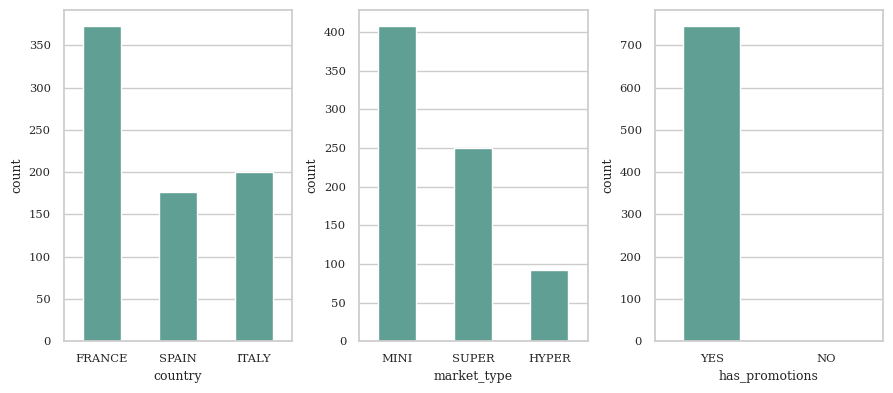

In [33]:
cat_names = ["country", "market_type", "has_promotions"]

# countplots
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9, 4))
index = 0
ax = ax.flatten()
for col_name in cat_names:
	sns.countplot(x = col_name, data = merged_df, ax = ax[index], width = 0.5)
	index += 1
plt.tight_layout()

We can make the following observations.
- As for the variable `country`, the most numerous class is $\texttt{FRANCE}$, while $\texttt{SPAIN}$ and $\texttt{ITALY}$ have a similar number of observations.
- The majority of the markets are $\texttt{MINI}$ markets, while the number of $\texttt{HYPER}$ markets is pretty low.
- Almost all the markets have the possibility of getting promotions.

Note that the last countplot suggests that the number of observations with `has_promotion` equal to $\texttt{NO}$ is close to $0$. The exact number is in fact very low. We report it below.

In [34]:
print("- number of rows for which has_promotions is NO =", len(merged_df[merged_df["has_promotions"] == "NO"]))

- number of rows for which has_promotions is NO = 4


Let us now look at the boxplots in order to see if there is any outlier. 
We display only the ones corresponding to *quantitative* variables as for this purpose boxplots are not appropriate for *categorical* variables.

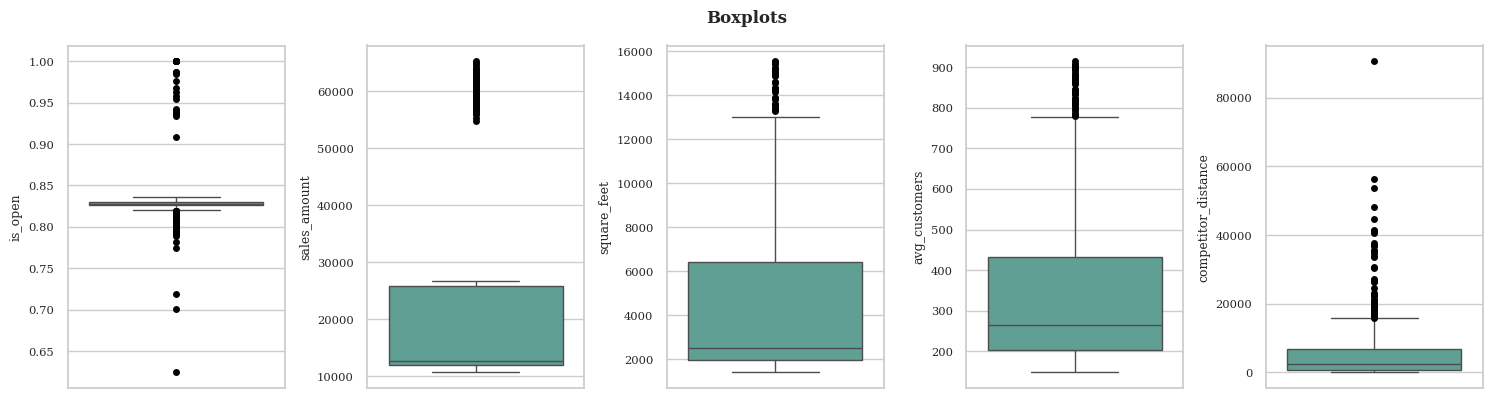

In [35]:
quant_names = ["is_open", "sales_amount", "square_feet", "avg_customers", "competitor_distance"]

# boxplots
fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
ax = ax.flatten()
index = 0
for col_name in quant_names:
	sns.boxplot(y = col_name, data = merged_df, ax = ax[index],
		flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
	index += 1
fig.suptitle("Boxplots", weight = "bold").set_fontsize("12")
plt.tight_layout()
plt.show()

As we can notice, in the variables `sales_amount`, `square_feet` and `avg_costumers` the ouliers seem to be the observations that reach the higher values, which of course correspond to the markets whose type is $\texttt{HYPER}$. This is probably due to the very small size of the class $\texttt{HYPER}$ if compared to the other two. <br>
As for the variables `is_open` and `competitor_distance`, they both seem to have a high percentage of outliers, which is a priori unexplainable. It might be useful to split the dataset with respect to the market type in order to see wether we can say something more. <br>
Before doing so, let us compute the percentage of outliers for each variable by exploiting the interquartile range ($\texttt{iqr}$). I.e., we compute the proportion of values which fall inside the following interval:
$$(-\infty, \texttt{quantile}(0.25) - 1.5 \cdot \texttt{iqr}] \cup [\texttt{quantile}(0.75) + 1.5 \cdot \texttt{iqr}, +\infty),$$
where $\texttt{iqr} = \texttt{quantile}(0.75) - \texttt{quantile}(0.25)$.

In [36]:
# percentage of outliers per column
merged_df_mt = merged_df.drop("market_type", axis = 1)
print("- percentage of outliers:")
for col_name, col in merged_df_mt[quant_names].items():
	q1 = col.quantile(0.25)
	q3 = col.quantile(0.75)
	iqr = q3 - q1
	outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
	print("\t - " + col_name + " = " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

- percentage of outliers:
	 - is_open = 9.33%
	 - sales_amount = 12.27%
	 - square_feet = 4.27%
	 - avg_customers = 5.07%
	 - competitor_distance = 8.8%


As expected, the percentage of outliers is quite high, especially for the variables `is_open`, `sales_amount` and `competitor_distance`.

Let us now divide the dataset by market type and then display again the boxplots together with the percentage of outliers computed by using the interquartile range.

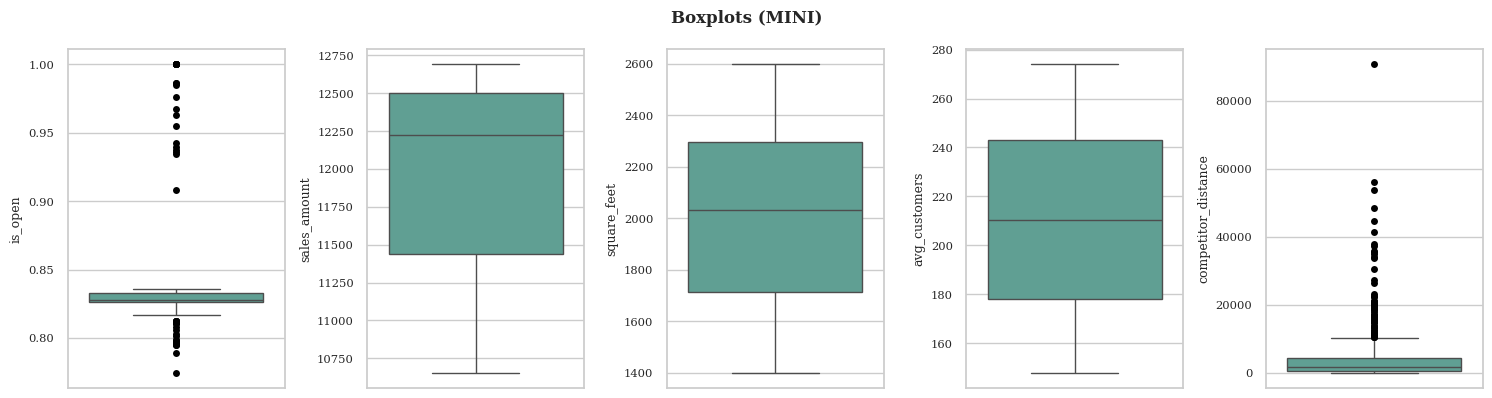

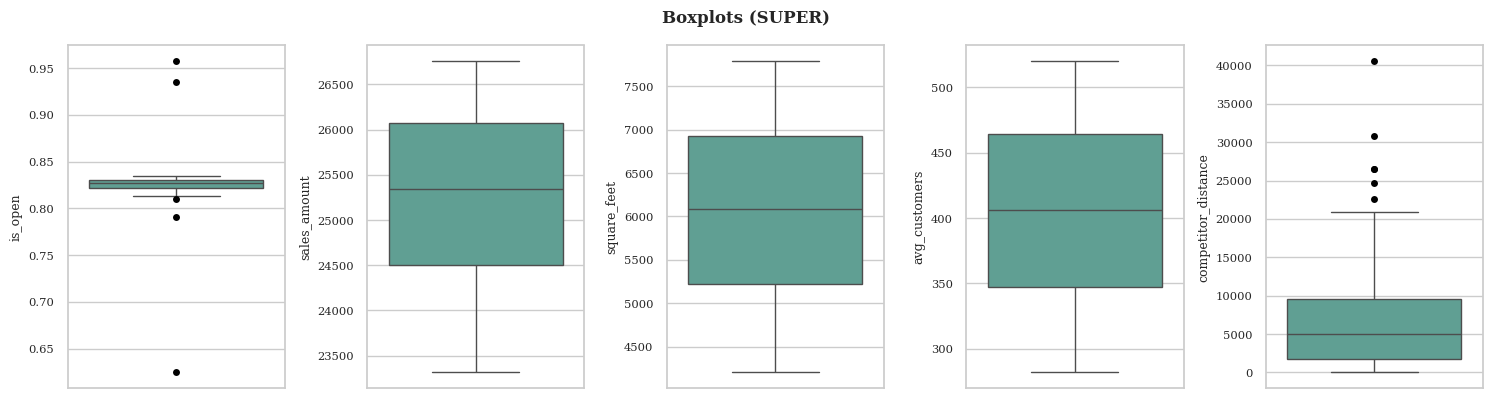

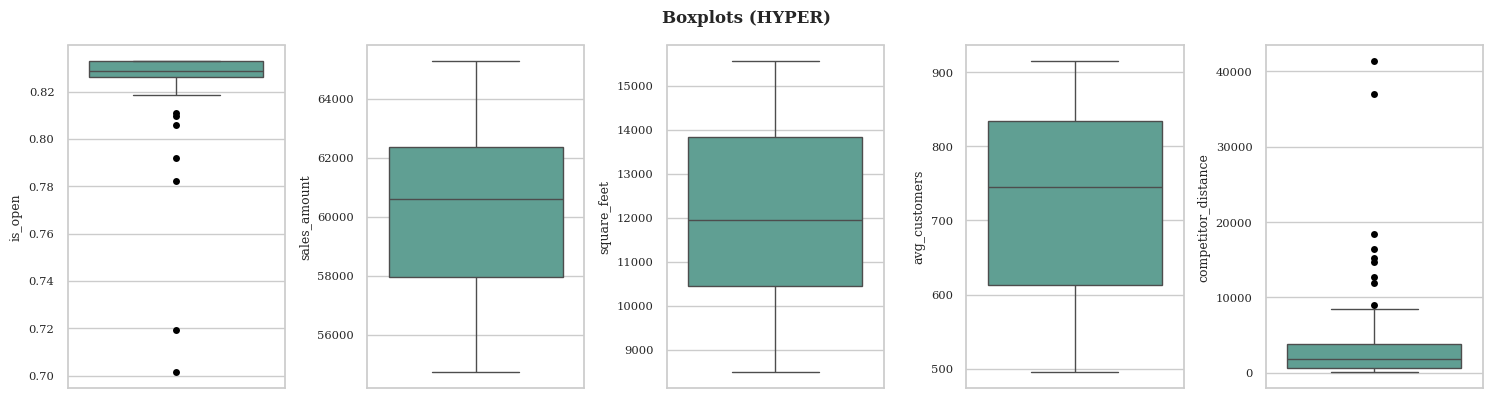

In [37]:
# boxplots (by market_type)
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type]
	fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
	ax = ax.flatten()
	index = 0
	for col_name in quant_names:
		sns.boxplot(y = col_name, data = merged_df_mt, ax = ax[index],
			flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
		index += 1
	fig.suptitle("Boxplots (" + market_type + ")", weight = "bold").set_fontsize("12")
	plt.tight_layout()
	plt.show()

In [38]:
# percentage of outliers per column (by market_type)
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type].drop("market_type", axis = 1)
	print("- " + market_type + ", percentage of outliers:")
	for col_name, col in merged_df_mt[quant_names].items():
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		iqr = q3 - q1
		outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
		print("\t - " + col_name + " = " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

- MINI, percentage of outliers:
	 - is_open = 10.54%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 15.2%
- SUPER, percentage of outliers:
	 - is_open = 2.0%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 2.4%
- HYPER, percentage of outliers:
	 - is_open = 7.61%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 9.78%


The first thing to observe is that now the variables `sales_amount`, `square_feet` and `avg_costumers` have no outliers, which means that for each type of market the observations are homogeneous with respect to these variables. <br>
As for the variables `is_open` and `competitor_distance`, they have a high percentage of outliers for both $\texttt{MINI}$ and $\texttt{HYPER}$ markets, and a lower one for $\texttt{SUPER}$ markets.
This allows us to say that both these values do not depend on the type of market we are considering.

### Categorical variables encoding

We now encode the *categorical* variables: as for the variable `has_promotion` we just turn $\texttt{YES}$ to $1$ and $\texttt{NO}$ to $0$, while the variables `country` and `market_type` are both substituted by two dummy variables: `is_spain`, `is_italy` and `is_mini`, `is_super` respectively. In particular, `is_spain` is $1$ if the market is in $\texttt{SPAIN}$, $0$ otherwise; `is_mini` is $1$ if the market is $\texttt{MINI}$, $0$ otherwise, and so on. <br>
Notice that we do not need additional dummy variables for the classes $\texttt{FRANCE}$ and $\texttt{HYPER}$ since all the information is contained in the other dummy variables.

In [39]:
# split country and market_type in boolean variables:
# - we create a copy of both columns
# - we encode the two copies of country and market_type in dummy variable
merged_df = pd.concat([merged_df, merged_df["country"].rename("is_italy"),
	merged_df["market_type"].rename("is_super")], axis = 1)
merged_df.rename(columns = {"country": "is_spain", "market_type": "is_mini"}, inplace = True)
merged_df = merged_df[["sales_amount", "is_open", "is_spain", "is_italy", "is_mini", "is_super",
	"square_feet", "avg_customers", "competitor_distance", "has_promotions"]]
merged_df["is_spain"] = merged_df["is_spain"].map({"SPAIN": 1, "FRANCE": 0, "ITALY": 0})
merged_df["is_italy"] = merged_df["is_italy"].map({"SPAIN": 0, "FRANCE": 0, "ITALY": 1})
merged_df["is_mini"] = merged_df["is_mini"].map({"MINI": 1, "SUPER": 0, "HYPER": 0})
merged_df["is_super"] = merged_df["is_super"].map({"MINI": 0, "SUPER": 1, "HYPER": 0})

# encoding has_promotions: 1 = YES and 0 = NO
merged_df["has_promotions"] = merged_df["has_promotions"].map({"YES": 1, "NO": 0})

display(merged_df)

,sales_amount,is_open,is_spain,is_italy,is_mini,is_super,square_feet,avg_customers,competitor_distance,has_promotions
0,12609.579520,0.827397,0,0,1,0,2437,248,58,1
1,26573.814219,0.820513,0,0,0,1,6403,493,300,1
2,26124.283769,0.830137,0,0,0,1,7544,340,1598,1
3,11856.326518,0.820513,1,0,1,0,1940,165,2068,1
4,12392.551096,0.824658,0,0,1,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...
745,12570.549505,0.830137,0,0,1,0,1691,272,1843,1
746,12375.246473,0.820513,0,0,1,0,1462,159,547,1
747,26404.851308,0.827397,0,0,0,1,5946,488,2743,1
748,12542.256577,0.818681,0,0,1,0,1413,239,1920,1


### Scatterplots & correlation matrix

Finally, let us display the scatterplots of each variable vs. `sales_amount` and the correlation matrix. We do so in order to see wether there is any predictor which potentially might affect more the target variable.

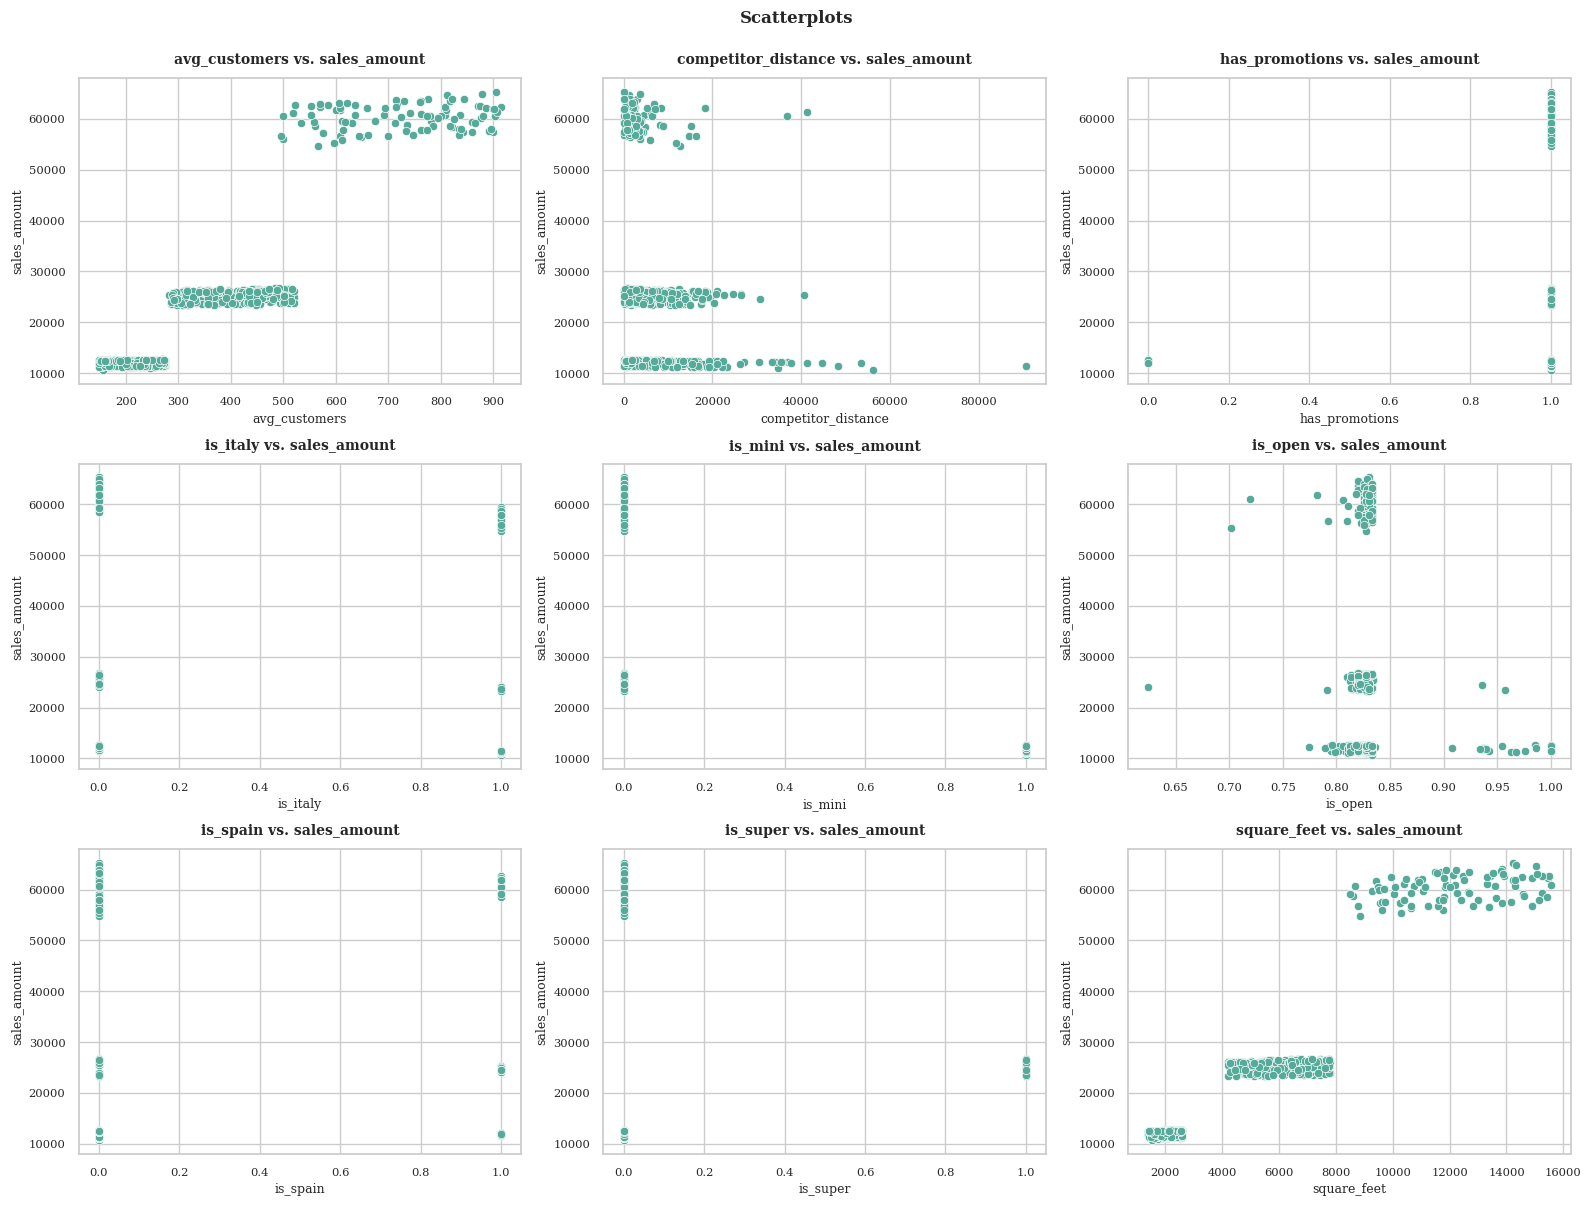

In [40]:
# scatterplots
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (16, 12))
index = 0
ax = ax.flatten()
for col_name in merged_df.columns.difference(["sales_amount"]):
	current_plot = sns.scatterplot(y = merged_df["sales_amount"], x = merged_df[col_name], ax = ax[index])
	ax[index].set_title(col_name + " vs. sales_amount", weight = "bold", y = 1.02).set_fontsize("10")
	index = index + 1
fig.suptitle("Scatterplots", weight = "bold",  y = 1).set_fontsize("12")
plt.tight_layout()

As we might expect, the scatterplots `avg_costumers` vs. `sales_amount` and `sqaure_feet` vs. `sales_amount` (the first one and the last one respectively) contain three distinct clouds of points which correspond to $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets. 
There seem to be a direct proportionality between portions of `avg_costumers` and `square_feet` and the taget variable, however we cannot say the same if we consider each cloud separately, that is if we consider each market separately. We can still say that they can be helpful in explaining the target variable. <br>
Also the variables `is_mini` and `is_super` are related to the target: if a market is $\texttt{MINI}$ then it will have a low `sales_amount` value, if a market is $\texttt{SUPER}$ it will have a medium `sales_amount` value. <br>
The remaining scatterplots do not seem to show any explicit pattern.

Let us finally display the correlation matrix.

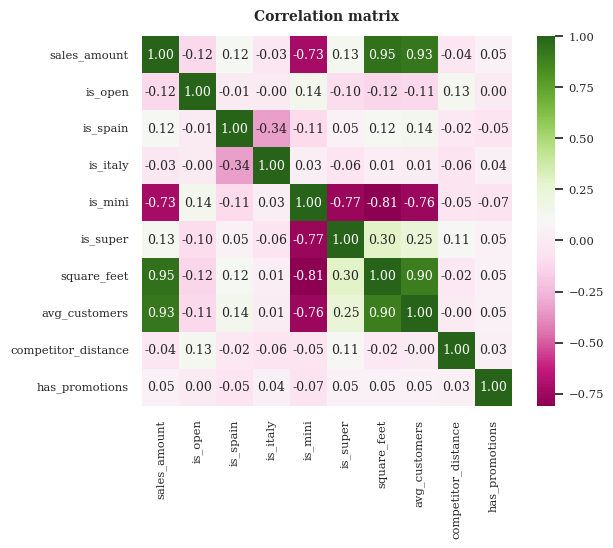

In [41]:
# correlation matrix
ax = sns.heatmap(merged_df.corr(), annot = True, cmap = "PiYG", fmt = ".2f", square = True)
ax.set_title("Correlation matrix", weight = "bold", y = 1.02).set_fontsize("10")
ax.tick_params(left = False, bottom = False)

The correlation between the target and the variables `square_feet` and `avg_costumers` (and also the correlation between them) is very high. Hence, we expect that both variables will play a major role in describing the target. <br>
Furthermore, we can observe that the variable `is_mini` is strongly correlated not only to `sales_amount` but also to `is_super`, `square_feet` and `avg_costumers`. So we expect also `is_mini` to be relevant in the target explaination.

# Objective 1

We consider here a linear relationship between target and predictors.

## Feature selection

Before fitting a linear model we perform feature selection in order to remove possible irrelevant variables. We report below the functions that carry out both forward and backward stepwise selection together with two other functions that compute and print the results of the selection procedure.

Notice that for computational reasons we decided not to use the best subset selection.

In [42]:
def calculate_metrics(y_test, y_pred, p):
	# description:
	# 	function to compute RSE, R2, and MSE of a linear model with p predictors.
	# input:
	# 	y_test 	= target observations
	# 	y_pred	= predicted values for the target observation
	# 	p		= number of predictors used to compute y_pred
	# output:
	# 	RSE		= relative standard error (RSE)
	# 	R2		= coefficient of determination (R^2)
	# 	MSE		= mean squared error (MSE)

	residuals = y_test - y_pred
	RSE = (sum(residuals ** 2) / (len(residuals) - p - 1)) ** 0.5
	R2 = 1 - sum(residuals ** 2) / sum((y_test - y_test.mean()) ** 2)
	MSE = (residuals ** 2).mean()
	return RSE, R2, MSE

def better_by_criteria(value_1, value_2, criteria):
	# description:
	#  	function to check wheather the first given error (value_1) is better than the second one (value_2) according to a fixed criteria.
	#  	if the criteria is MSE or RSE value_1 is better than value_2 when value_1 < value_2.
	#  	if the criteria is R2 value_1 is better than value_2 when value_1 > value_2.		
	# input:
	# 	value_1		= first of the two errors, we want to check whether is better than value_2
	# 	value_2		= second of the two errors
	# 	criteria	= RSE, R2 or MSE
	# output:
	# 	bool		= True if value_1 is better than value_2 by criteria, False otherwise

	if (criteria == "RSE") or (criteria == "MSE"):
		return (value_1 < value_2)
	elif (criteria == "R2"):
		return (value_1 > value_2)

def forward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# description:
	# 	implementation of the algorithm forward selection (v2).
	# 	in order to select the best number of features it is used a 5-fold cross validation.
	# input:
	#	training_method = method used to perform the linear regression (OLS, Ridge or Lasso)
	#	X				= predictors
	#	y				= target
	#	criteria		= criteria to decite which of the feature set is better (RSE, R2 or MSE)
	#	(alpha			= optional parameter used by Ridge and Lasso, set to 0.1 by default)
	# output:
	#	best_features 	= features selected by the best set of features selected (for each k)
	#	best_metrics 	= metrics obtained by applying the cross-validation to the best set of feature selected (for each k)

	# k-fold
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# initialize parameters
	# - p = number of total features
	# - best_features = list containing the best set of features selected (for each k)
	# - best_metrics = list containing the metrics (errors) obtained applying the k-fold cv to the best set of feature selected (for each k)
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf")
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())

	# list of the features inserted in the current model
	current_features = []
	# list of the selectable features
	remaining_features = list(X.columns)
	
	# k = number of features
	for k in range(0, p):
		# new_feature = feature to insert in the current model
		for new_feature in remaining_features:
			# model_features = features in the current model
			model_features = current_features + [new_feature]
			# X_subset = observations of the features in the current model
			# (add a constant for the intercept term)
			X_subset = X[model_features]
			X_subset = sm.add_constant(X_subset)  
			
			# cv_folds = empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0
			}

			# for each fold fit the model and estimate cv test error using the mean of the considered statistics in all folds
			for train_index, validation_index in kf.split(X_subset):
				# split X_subset in train and validation
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				
				# fit:
				# it is possible to select several training methods to perform the linear regression, depending from
				# the selected training_method we perform OLS, Ridge(alpha = alpha) or Lasso(alpha = alpha)
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return

				# predict
				y_pred = model.predict(X_validation)
				
				# compute ad update the regression errors: RSE, R2 and MSE
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k + 1)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
			
			# compute the k-fold errors
			cv_folds = {key: cv_folds[key] / number_folds for key in cv_folds.keys()}
			
			# if the estimation of the error is better (according to the selected criteria) we store metrics and features
			if better_by_criteria(cv_folds[criteria], best_metrics[k][criteria], criteria):
				best_metrics[k]["RSE"] = cv_folds["RSE"]
				best_metrics[k]["R2"] = cv_folds["R2"]
				best_metrics[k]["MSE"] = cv_folds["MSE"]
				best_features[k] = model_features
		
		# update current/remaining_features
		current_features = best_features[k]
		remaining_features = list(set(remaining_features) - set(current_features))

	return best_features, best_metrics

def backward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# description:
	# 	implementation of the algorithm backward selection (v2).
	# 	in order to select the best number of features it is used a 5-fold cross validation.
	# input:
	#	training_method = method used to perform the linear regression (OLS, Ridge or Lasso)
	#	X				= predictors
	#	y				= target
	#	criteria		= criteria to decite which of the feature set is better (RSE, R2 or MSE)
	#	(alpha			= optional parameter used by Ridge and Lasso, set to 0.1 by default)
	# output:
	#	best_features 	= features selected by the best set of features selected (for each k)
	#	best_metrics 	= metrics obtained by applying the cross-validation to the best set of feature selected (for each k)

	# k-fold
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# initialize parameters
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf")
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())

	# list of the features inserted in the current model
	current_features = list(X.columns)
	# list of the selectable features
	removable_features = [None]
	
	# k = number of features
	for k in range(p, 0, -1):
		# new_feature = feature to insert in the current model
		for new_feature in removable_features:
			model_features = list(set(current_features) - set([new_feature]))
			X_subset = X[model_features]
			X_subset = sm.add_constant(X_subset) 

			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0
			}

			for train_index, validation_index in kf.split(X_subset):
				# split in train and validation
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

				# fit
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return
				
				# predict
				y_pred = model.predict(X_validation)

				# compute ad update the regression errors
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE

			# compute the k-fold errors
			cv_folds = {key: cv_folds[key] / number_folds for key in cv_folds.keys()}
			
			# if the estimation of the error is better we store metrics and features
			if better_by_criteria(cv_folds[criteria], best_metrics[k - 1][criteria], criteria):
				best_metrics[k - 1]["RSE"] = cv_folds["RSE"]
				best_metrics[k - 1]["R2"] = cv_folds["R2"]
				best_metrics[k - 1]["MSE"] = cv_folds["MSE"]
				best_features[k - 1] = model_features

		# update current/remaining_features		
		current_features = best_features[k - 1]
		removable_features = current_features

	return best_features, best_metrics

def report_best_parameters(features, metrics, criteria, model_name = "", verbose = False):
	# description:
	# 	function to find and report (if in verbose mode) the best metrics in a list of metrics and their corresponding features.
	# input:
	# 	features 		= list of features associated to the metrics
	# 	metrics 		= list of dictionaries containing the 3 metrics
	#	criteria		= criteria to decite which of the metrics set is better (RSE, R2 or MSE)
	#	(model_name		= name of the model used to generate the metrics and the features
	#	verbose			= dummy variable, if True an extensive report is printed)
	
	p = len(metrics)
	criteria_list = [metrics[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	
	if verbose == True:
		if model_name != "":
			print(model_name + ", ", end = "")
		print("best parameters:\n\t- k =", criteria_best_k + 1, "\n\t- features =", features[criteria_best_k])
		print("\t- cv metrics:\n\t\t- RSE =", '%.6f' % metrics[criteria_best_k]["RSE"], "\n\t\t- R2 =",
			'%.6f' % metrics[criteria_best_k]["R2"], "\n\t\t- MSE =", '%.6f' % metrics[criteria_best_k]["MSE"])
	
	return features[criteria_best_k], metrics[criteria_best_k]

def plot_metrics(metrics, name_variables = "features"):
	# description:
	# 	function to plot lists of metrics (RSE, R2 and MSE).
	# input:
	# 	metrics 		= list of dictionaries containing the 3 metrics
	#	(name_variables	= name of the variables associated to the indexes of the list)

	p = len(metrics)
	_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
	index = 0
	ax = ax.flatten()
	for error_type in ["RSE", "R2", "MSE"]:
		# list of errors to be plotted
		error_list = [metrics[k][error_type] for k in range(p)]

		# plots
		sns.lineplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		sns.scatterplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		
		ax[index].set_title(error_type, weight = "bold", y = 1.02).set_fontsize("10")
		ax[index].set_xlabel("k (n. " + name_variables + ")")
		ax[index].set_ylabel(error_type + "(k)")
		index = index + 1
	plt.tight_layout()
	plt.show()

We perform here the forward feature selection for the multiple linear regression model with $\texttt{OLS}$ as fitting procedure. Moreover, among $\texttt{MSE}$, $\texttt{RSE}$ and $\texttt{R}^2$ (which are all computed via $5$-fold cross-validation), we use the $\texttt{RSE}$ metric to pick the best model, since it allows us the reduce more the number of predictors and at the same time to obtain an accuracy which is almost identical to the other two cases.

In [43]:
# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

OLS best (forward), best parameters:
	- k = 7 
	- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	- cv metrics:
		- RSE = 658.188759 
		- R2 = 0.998257 
		- MSE = 413572.984907


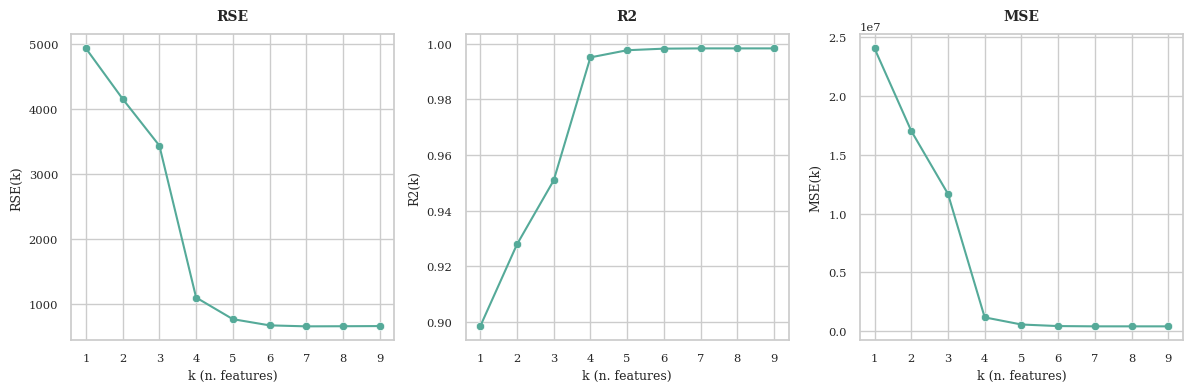

In [44]:
# model under analysis
model_name = "OLS best (forward)"

# criteria = method to compare the performance of groups of features
# training_method = algorithm to perform the linear regression
criteria = "RSE"
training_method = "OLS"

# compute and display the results
list_best_features, list_best_metrics = forward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(list_best_features, list_best_metrics, criteria, model_name, verbose = True)
plot_metrics(list_best_metrics)

# store cv errors
cv_errors = pd.DataFrame([best_metrics])
cv_errors = cv_errors.rename(index = {0: model_name})

The forward feature selection eliminates the variables `is_open` and `has_promotions`. It seems reasonable since, as we saw, `has_promotions` is $\texttt{YES}$ always but $4$ times (hence it is quite uninformative), while `is_open` is almost uncorrelated to both the target variable and the other predictors. 

The above plot shows the error metrics of the best model at each iteration of the selection procedure. We can observe that in each plot the stability is reached with $6\,/\,7$ features, hence adding more features does not give any relevant benefit. 

Finally, notice that with $7$ features we obtain an $\texttt{R}^2$ value which is almost $1$ (precisely $0.998$). So the model seems to be able to explain very well the variability of the target variable.

## Best linear model analysis

We now analyze the best multiple linear regression model found above. 

After splitting the dataset in train and test sets, we fit the model and then compute its accuracy.

In [45]:
# split in train and test:
# predictors = X[best_features], target = y
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size = 0.2, random_state = 2023)

# fit (OLS)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# predict 
y_pred = model.predict(X_test_with_intercept)

# model accuracy
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print(model_name + ", test metrics:\n\t- RSE =", '%.6f' % RSE, "\n\t- R2 =", '%.6f' % R2, "\n\t- MSE =", '%.6f' % MSE)

OLS best (forward), test metrics:
	- RSE = 575.506116 
	- R2 = 0.998530 
	- MSE = 313542.900747


Then, we display the coefficients' estimates together with the corresponding *standard errors* (*SE*), *t-statistics*, *p-values* and $95\%$ *confidence intervals*.

In [46]:
# coefficients (OLS)
coefficients = model.params

# summary of coefficients and relevant statistics 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
display(summary_coeff)

,,ols estimation,SE,t-stats,p-value
0,const,55742.442570,436.364747,127.742773,0.000000e+00
1,square_feet,0.273939,0.026446,10.358259,3.211469e-23
2,avg_customers,2.944094,0.396751,7.420511,4.073315e-13
3,is_super,-32524.127510,224.107492,-145.127355,0.000000e+00
4,is_mini,-44017.672907,346.367329,-127.083790,0.000000e+00
5,is_italy,-2065.714140,63.466797,-32.547950,5.456902e-134
6,is_spain,-897.419660,67.839991,-13.228476,3.492094e-35
7,competitor_distance,-0.020311,0.003100,-6.552110,1.234140e-10


In [47]:
# report 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)
print(model_name + ", 95% confidence intervals of the coefficients:")
for index, value in coefficients.items():
	current_conf_int = confidence_intervals.loc[index].values
	print("\t-", index, end = "")
	print("\t" if (index == "competitor_distance") else "\t\t\t" if (index == "const") else "\t\t", end = "")
	print("in [" + str('%.6f' % current_conf_int[0]) + ", " + str('%.6f' % current_conf_int[1]) + "]")

OLS best (forward), 95% confidence intervals of the coefficients:
	- const			in [54885.431255, 56599.453885]
	- square_feet		in [0.221999, 0.325879]
	- avg_customers		in [2.164884, 3.723304]
	- is_super		in [-32964.269977, -32083.985043]
	- is_mini		in [-44697.931159, -43337.414656]
	- is_italy		in [-2190.361614, -1941.066667]
	- is_spain		in [-1030.655995, -764.183324]
	- competitor_distance	in [-0.026399, -0.014223]


All the *p-values* are a significatively lower than $0.05$ (three of them are even $0$). Hence, all the selected predictors and the intercept should be considered.

### Residuals analysis

We now move to the residuals analysis. In particular, we first check if the error terms are uncorrelated, and then we try to understand if their variance is approximatively constant, i.e. we control wether our fitted linear model is heteroscedastic.

In order to check the correlation of error terms we first plot the residuals, then we quantify the correlation by computing both the autocorrelation with the $\texttt{lagged}(1)$ residuals and the *Durbin-Watson statistic*.

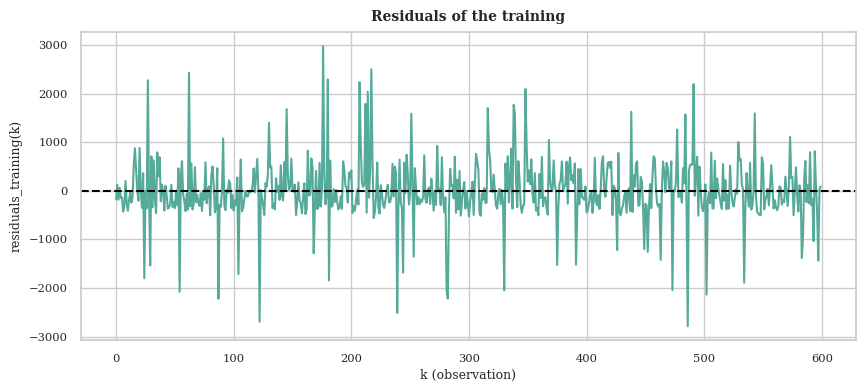

In [48]:
# plot residuals of the training data
residuals_training = model.resid
plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.title("Residuals of the training", weight = "bold", y = 1.01).set_fontsize("10")
plt.xlabel("k (observation)")
plt.ylabel("residuals_training(k)")
plt.show()

In [49]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation =", '%.6f' % autocorrelation, "\n- durbin-watson statistic =", '%.6f' % durbin_watson)

- autocorrelation = 0.000782 
- durbin-watson statistic = 1.943938


Both the plot and the above values suggest there is no correlation of error terms. Indeed:
- in the plot there is no discernible pattern;
- the autocorrelation value is close to $0$;
- the *Durbin-Watson* statistic is approximatively $2$. 


In order to check heteroscedasticity, we first plot the training fitted values vs. the training residuals, then we perform the *Breush-Pagan Lagrange multiplier test*.

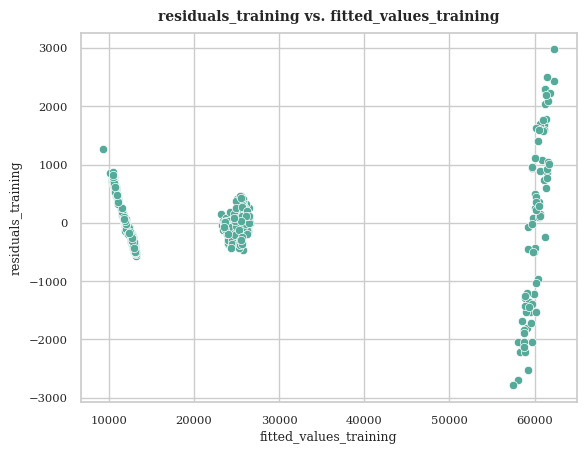

In [50]:
# scatterplot of residuals_training vs. fitted_values_training
# - fitted_values_training = model.predict(X_train_with_intercept) 
# - residuals_training = residual of the training data
fig = sns.scatterplot(x = model.predict(X_train_with_intercept), y = residuals_training)
fig.set_title("residuals_training vs. fitted_values_training", weight = "bold", y = 1.01).set_fontsize("10")
fig.set_xlabel("fitted_values_training")
fig.set_ylabel("residuals_training")
plt.show()

In [51]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic =", '%.6f' % lzip(name, test)[0][1], "\n- p-value =", '%.6e' % lzip(name, test)[1][1])

- lagrange multiplier statistic = 335.148416 
- p-value = 1.857277e-68


It is already evident from the plot that the variance of errors terms is not constant: the points are not uniformely distributed around $0$. This is confirmed by the *Breush-Pagan Lagrange multiplier test*: the *p-value* is very close to $0$, hence the null hypothesis ($H_0$) of homoscedasticity is rejected. <br>
A standard approach for solving this problem is to transform the target by using the logarithm. We will explore this approach at the end of this section but it will not be part of the solution to **Objective 1**, since when we consider the logarithm the relationship between target and predictors is no longer linear.

### Collinearity

The last thing we need to check is collinearity. We compute it by using the *variance inflation factor* (*VIF*).

In [52]:
# collinearity
vif = pd.DataFrame()
vif["VIF factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["feature"] = X_train.columns
display(vif)

,VIF factor,feature
0,16.135825,square_feet
1,19.946057,avg_customers
2,1.889666,is_super
3,2.085008,is_mini
4,1.572465,is_italy
5,1.543671,is_spain
6,1.451100,competitor_distance


The *VIF* factor is overall quite low, except for the variables `square_feet` and `avg_costumers`. We could have expected it since, as we saw, these variables are highly correlated. Despite the high *VIF* factor we decide not to remove one of these two variables as they are among the first ones to be selected in both forward and backward selection, which means that they are both important in explaining/predicting the target.

### Backward selection

Here we run the backward feature selection for the multiple linear regression model with $\texttt{OLS}$ as fitting procedure. We only do this to check whether the model selected as best is the same as the model selected by the forward procedure. Moreover, in order to mantain a consistency with what was done before, among $\texttt{MSE}$, $\texttt{R}^2$ and $\texttt{RSE}$, we use again the $\texttt{RSE}$ metric to pick the best model.

In [53]:
# reload the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

OLS best (backward), best parameters:
	- k = 7 
	- features = ['is_italy', 'avg_customers', 'is_spain', 'square_feet', 'competitor_distance', 'is_super', 'is_mini']
	- cv metrics:
		- RSE = 658.188759 
		- R2 = 0.998257 
		- MSE = 413572.984907


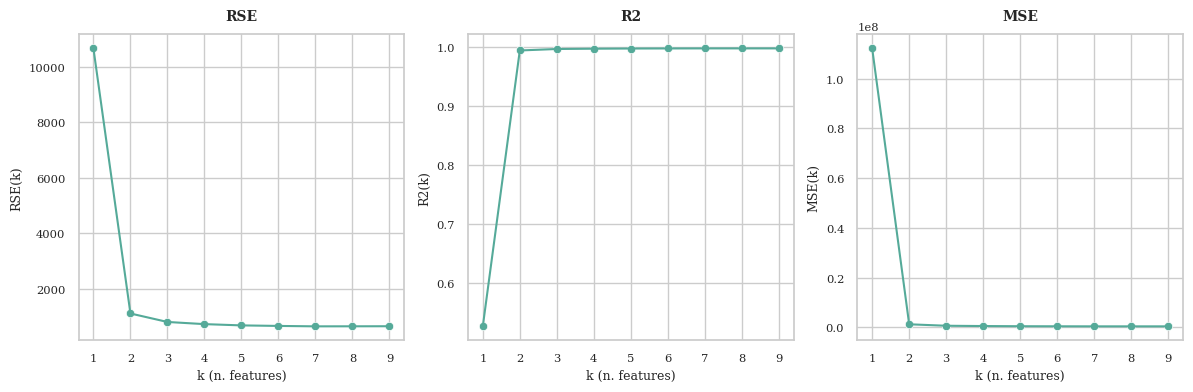

In [54]:
# model 
model_name = "OLS best (backward)"

# criteria and training_method
criteria = "RSE"
training_method = "OLS"

# compute and display the results
list_best_features, list_best_metrics = backward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(list_best_features, list_best_metrics, criteria, model_name, verbose = True)
plot_metrics(list_best_metrics)

The linear model selected as *best* is the same as the one selected by the forward procedure. The only relevant information here is that, as we can see from the above plots, the error metrics decrease/increase more rapidly than in forward selection, however this does not affect the final result.

## Shrinkage methods

In this section we perform the forward feature selection for the multiple linear regression model by estimating the coefficients with $\texttt{Ridge regression}$ and $\texttt{Lasso}$. The aim here is to check wether we can reach a better accuracy by applying shrinkage techniques.

Before running the two procedures we standardize the dataset.

In [55]:
# X_scaled = standardized version of X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

### Ridge

Here we perform the forward feature selection for the multiple linear regression with $\texttt{Ridge regression}$. We do it for each following value of the tuning paramater of $\texttt{Ridge regression}$: $0.001$, $0.01$, $0.1$, $1$. We report below the features and the error metrics associated with the selected best model, where, again, with best we mean in terms of $\texttt{RSE}$.

In [56]:
# criteria and training_method (we test several values of alpha for the method)
criteria = "RSE"
training_method = "Ridge"
alpha_values = [0.001, 0.01, 0.1, 1]

# select best alpha (using forward_selection_v2) and save the related features and metrics
best_alpha_dict = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"alpha": 0,
	"k": 0,
	"features": [],
}
for alpha in alpha_values:
	list_best_features, list_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(list_best_features, list_best_metrics, criteria)
	if better_by_criteria(best_metrics[criteria], best_alpha_dict[criteria], criteria):
		best_alpha_dict["RSE"] = best_metrics["RSE"]
		best_alpha_dict["R2"] = best_metrics["R2"]
		best_alpha_dict["MSE"] = best_metrics["MSE"]
		best_alpha_dict["alpha"] = alpha
		best_alpha_dict["k"] = len(best_features)
		best_alpha_dict["features"] = best_features

# model 
model_name = training_method + " best (alpha = " + str(best_alpha_dict["alpha"]) + ")"

# report the results
print(model_name + ", ", end = "")
print("best parameters:\n\t- k =", best_alpha_dict["k"], "\n\t- features =", best_alpha_dict["features"])
print("\t- cv metrics:\n\t\t- RSE =", '%.6f' % best_alpha_dict["RSE"], "\n\t\t- R2 =",
	'%.6f' % best_alpha_dict["R2"], "\n\t\t- MSE =", '%.6f' % best_alpha_dict["MSE"])

# store cv errors
cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_dict.items() if key in ["RSE", "R2", "MSE"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Ridge best (alpha = 0.001), best parameters:
	- k = 7 
	- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	- cv metrics:
		- RSE = 658.198925 
		- R2 = 0.998257 
		- MSE = 413580.418770


In [57]:
print("- RSE(" + model_name + ") - RSE(OLS best (forward)) =", 
	'%.6f' % (cv_errors["RSE"][model_name] - cv_errors["RSE"]["OLS best (forward)"]))

- RSE(Ridge best (alpha = 0.001)) - RSE(OLS best (forward)) = 0.010166


With $\texttt{Ridge regression}$ we obtain the same best features as the ones obtained with $\texttt{OLS}$ and almost the same error values. 
In particular, as we can see from the above computation, the $\texttt{RSE}$ is larger by $0.01$ than the value obtained with $\texttt{OLS}$.
Hence, we can conclude that using $\texttt{Ridge regression}$ does not improve the model's accuracy.

### Lasso

Here we perform the forward feature selection for the multiple linear regression with $\texttt{Lasso}$. As we did for $\texttt{Ridge regression}$ we try the following values of the tuning paramater of $\texttt{Lasso}$: $0.001$, $0.01$, $0.1$, $1$. We report below the features and the error metrics associated with the selected best model.

In [58]:
# criteria and training_method (we test several values of alpha for the method)
criteria = "RSE"
training_method = "Lasso"
alpha_values =  0.001, 0.01, 0.1, 1]

# select best alpha (using forward_selection_v2) and save the related features and metrics
best_alpha_dict = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"alpha": 0,
	"k": 0,
	"features": [],
}
for alpha in alpha_values:
	list_best_features, list_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(list_best_features, list_best_metrics, criteria)
	if better_by_criteria(best_metrics[criteria], best_alpha_dict[criteria], criteria):
		best_alpha_dict["RSE"] = best_metrics["RSE"]
		best_alpha_dict["R2"] = best_metrics["R2"]
		best_alpha_dict["MSE"] = best_metrics["MSE"]
		best_alpha_dict["alpha"] = alpha
		best_alpha_dict["k"] = len(best_features)
		best_alpha_dict["features"] = best_features

# model 
model_name = training_method + " best (alpha = " + str(best_alpha_dict["alpha"]) + ")"

# report the results
print(model_name + ", ", end = "")
print("best parameters:\n\t- k =", best_alpha_dict["k"], "\n\t- features =", best_alpha_dict["features"])
print("\t- cv metrics:\n\t\t- RSE =", '%.6f' % best_alpha_dict["RSE"], "\n\t\t- R2 =",
	'%.6f' % best_alpha_dict["R2"], "\n\t\t- MSE =", '%.6f' % best_alpha_dict["MSE"])

# store cv errors
cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_dict.items() if key in ["RSE", "R2", "MSE"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Lasso best (alpha = 0.001), best parameters:
	- k = 7 
	- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	- cv metrics:
		- RSE = 658.189061 
		- R2 = 0.998257 
		- MSE = 413573.209576


In [59]:
print("- RSE(" + model_name + ") - RSE(OLS best (forward)) =", 
	'%.6f' % (cv_errors["RSE"][model_name] - cv_errors["RSE"]["OLS best (forward)"]))

- RSE(Lasso best (alpha = 0.001)) - RSE(OLS best (forward)) = 0.000302


Similarly to what happens with $\texttt{Ridge regression}$, also with $\texttt{Lasso}$ we obtain the same best features as the ones obtained with $\texttt{OLS}$ and similar error values. 
In particular, here the $\texttt{RSE}$ is larger by $0.0003$ than the $\texttt{RSE}$ obtained with $\texttt{OLS}$.

We compare below the error values of the best models obtained by applying the forward feature selection with $\texttt{OLS}$, $\texttt{Ridge regression}$ and $\texttt{Lasso}$ respectively.

In [60]:
display(cv_errors)

,RSE,R2,MSE
OLS best (forward),658.188759,0.998257,413572.984907
Ridge best (alpha = 0.001),658.198925,0.998257,413580.418770
Lasso best (alpha = 0.001),658.189061,0.998257,413573.209576


In conclusion, we can say that in this specific case the shrinkage techniques do not provide significative improvements.

## Dimensionality reduction techniques

Finally we consider the dimensionality reduction methods, in particular $\texttt{PCA}$ and $\texttt{PLS}$.

### PCA

Hereafter we write a function that allows us to perform $\texttt{PCA}$ for all possible numbers of principal components ($k = 1, \dots, 9$). The function also returns the estimated test errors (via a $5$-fold cross validation). Then, we report the graph of $\texttt{RSE}$, $\texttt{R}^2$ and $\texttt{MSE}$ as the number of selected principal components varies.

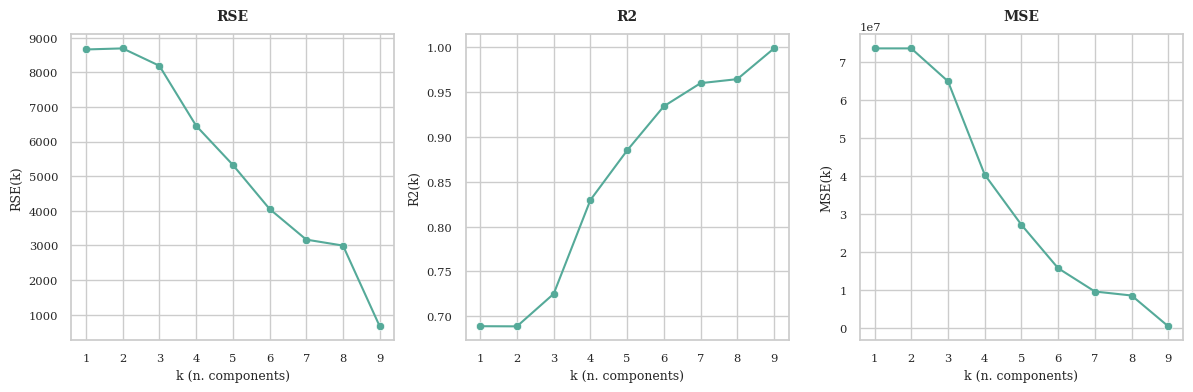

In [61]:
def pca_regression(X, y):
	# description:
	# 	implementation of the algorithm to select the number of components to ch0ose for the PCA.
	# 	in order to select the best number of components it is used a 5-fold cross validation.
	# input:
	#	X				= predictors
	#	y				= target
	# output:
	#	best_features 	= features selected by the best model selected (for each k)
	#	best_metrics 	= metrics obtained by applying the cross-validation to the best model selected (for each k)

	# k-fold
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

	# X_scaled = standardized version of X
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	# - p = number of total features
	# - errors_pca = list containing the components selected (for each k)
	p = X_scaled.shape[1]
	errors_pca_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pca = []
	for _ in range(p):
		errors_pca.append(errors_pca_k.copy())

	# k = number of features
	for k in range(1, p + 1):
		# transform X_scaled using k components for PCA
		# (add a constant for the intercept term)
		pca = PCA(n_components = k)
		X_pca = pca.fit_transform(X_scaled)
		X_pca = pd.DataFrame(X_pca)
		X_pca = sm.add_constant(X_pca)  
		
		# cv_folds = empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		
		for train_index, validation_index in kf.split(X_pca):
			# split in train and validation
			X_train, X_validation = X_pca.iloc[train_index], X_pca.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			
			# fit
			model = sm.OLS(y_train, X_train).fit()
			
			# predict
			y_pred = model.predict(X_validation)
			
			# compute ad update the regression errors
			RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_train.shape[1])
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		
		# compute the k-fold errors
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}

		# store the metrics
		errors_pca[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pca[k - 1]["R2"] = cv_folds["R2"]
		errors_pca[k - 1]["MSE"] = cv_folds["MSE"]
		
	return errors_pca

errors_pca = pca_regression(X, y)
plot_metrics(errors_pca, "components")

Looking at all three plots it is evident that the number of principal components that should be selected is $9$ (the curve continues to significatively decrease/increase until the maximum number of components is reached). This does not allow us to achieve a dimensionality reduction, which is the reason why $\texttt{PCA}$ is normally performed. We actually expected this because $\texttt{PCA}$, in general, is not a suitable method when you have both categorical and quantitative variables.

Notice that even if we perform $\texttt{PCA}$ with $9$ principal components we get an $\texttt{RSE}$ value that exceeds by $6.6$ the one we obtained before with the best linear regression (with $\texttt{OLS}$). Hence we do not attain any improvement by applying this technique. The exact computation is found below.

In [62]:
# number of principal components consideres
n_components = 9
# model 
model_name = "PCA (k = " + str(n_components) +")"
# print difference RSE
print("- RSE(" + model_name + ") - RSE(OLS best (forward)) =",
	'%.6f' % (errors_pca[n_components - 1]["RSE"] - cv_errors["RSE"]["OLS best (forward)"]))

# store cv errors
cv_errors = pd.concat([cv_errors, pd.DataFrame([errors_pca[n_components - 1]])])
cv_errors = cv_errors.rename(index = {0: model_name})

- RSE(PCA (k = 9)) - RSE(OLS best (forward)) = 6.555111


### PLS

Let us now turn to $\texttt{PLS}$. Similar to what we did for $\texttt{PCA}$, we write a function to perform $\texttt{PLS}$ with every possible number of components ($k = 1, \dots, 9$). We display again the graph of $\texttt{RSE}$, $\texttt{R}^2$ and $\texttt{MSE}$ as the number of selected components varies.

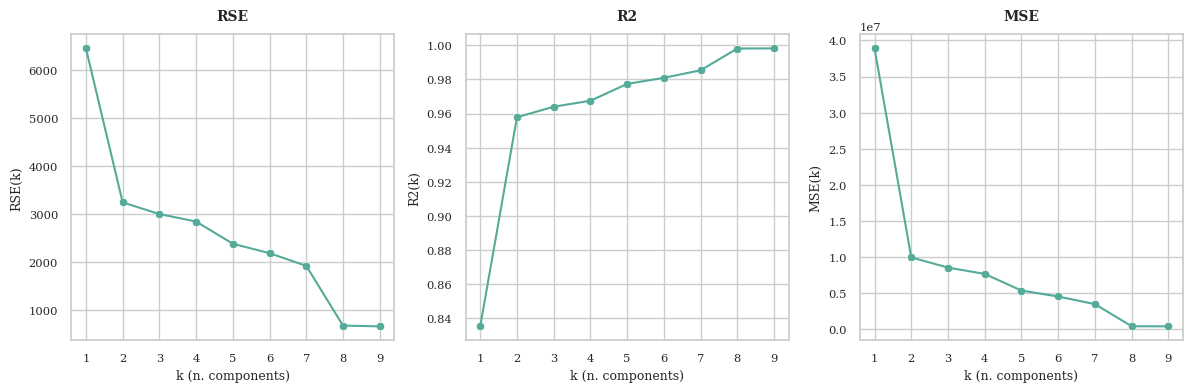

In [63]:
def pls_regression(X, y):
	# description:
	# 	implementation of the algorithm to select the number of components to choose for the PLS.
	# 	in order to select the best number of components it is used a 5-fold cross validation.
	# input:
	#	X				= predictors
	#	y				= target
	# output:
	#	best_features 	= features selected by the best model selected (for each k)
	#	best_metrics 	= metrics obtained by applying the cross-validation to the best model selected (for each k)

	# k-fold
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

	# X_scaled = standardized version of X
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pls_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pls = []
	for _ in range(p):
		errors_pls.append(errors_pls_k.copy())

	# k = number of features
	for k in range(1, p + 1):
		# transform X_scaled using k components for PLS
		pls = PLSRegression(n_components = k) 

		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		
		for train_index, validation_index in kf.split(X_scaled):
			# split in train and validation
			X_train, X_validation = X_scaled.iloc[train_index], X_scaled.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			
			# fit
			pls.fit(X_train, y_train)

			# predict
			y_pred = pls.predict(X_validation)
			y_pred = pd.Series(y_pred)

			# compute ad update the regression errors
			RSE, R2, MSE = calculate_metrics(y_validation.reset_index(drop = True), y_pred, X_train.shape[1]) 
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		
		# compute the k-fold errors
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		
		# store the metrics
		errors_pls[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pls[k - 1]["R2"] = cv_folds["R2"]
		errors_pls[k - 1]["MSE"] = cv_folds["MSE"]
	
	return errors_pls

errors_pls = pls_regression(X, y)
plot_metrics(errors_pls, "components")

Here the graphs suggest the choice of $8\,/\,9$ components. As before, this would lead to a missed dimensionality reduction.
Furthermore, if we look at the values of the $\texttt{RSE}$ obtained by selecting $8$ and $9$ components, we can observe that $\texttt{PLS}$ does not improve the accuracy of the best linear regression (with $\texttt{OLS}$). The computation is found below.

In [64]:
# 8 components consideres
n_components = 8
# model
model_name = "PLS (k = " + str(n_components) +")"
# print difference RSE
print("- RSE(" + model_name + ") - RSE(OLS best (forward)) =",
	'%.6f' % (errors_pls[n_components - 1]["RSE"] - cv_errors["RSE"]["OLS best (forward)"]))

# 9 components consideres
n_components = 9
# model
model_name = "PLS (k = " + str(n_components) +")"
# print difference RSE
print("- RSE(" + model_name + ") - RSE(OLS best (forward)) =",
	'%.6f' % (errors_pls[n_components - 1]["RSE"] - cv_errors["RSE"]["OLS best (forward)"]))

# store cv errors (9 components)
cv_errors = pd.concat([cv_errors, pd.DataFrame([errors_pca[n_components - 1]])])
cv_errors = cv_errors.rename(index = {0: model_name})

- RSE(PLS (k = 8)) - RSE(OLS best (forward)) = 19.726349
- RSE(PLS (k = 9)) - RSE(OLS best (forward)) = 4.176771


## Conclusions

We can conclude that the best model found so far is the multiple linear regression optimized through $\texttt{OLS}$, with the following predictors: `square_feet`, `avg_customers`, `is_super`, `is_mini`, `is_italy`, `is_spain` and `competitor_distance`.

In order to answer to the request in **Objective 1**, i.e. understanding the delta changes, we first fit the model with all the observations and then look at the estimated coefficients.

$\textit{Remark}:$ We recall that the coefficient $\beta_j$ (associated to the predictor $X_j$) estimated by a linear regression, coincides with the slope of the projection of the regression line on the $2$-dimensional space spanned by the target and $X_j$. Hence a $1$-unit increase in the $j^{\text{th}}$ predictor leads to a $\beta_j$-unit variation in the target.

In [65]:
# fit (OLS)
X_with_intercept = sm.add_constant(X[best_features])
model = sm.OLS(y, X_with_intercept).fit()

# coefficient estimates 
coefficients = pd.DataFrame(model.params)
coefficients.rename(columns = {0: "coefficients"})
display(coefficients)

,0
const,55694.653789
square_feet,0.278219
avg_customers,3.130872
is_super,-32575.760977
is_mini,-44017.201339
is_italy,-2044.762121
is_spain,-940.543223
competitor_distance,-0.019097


As for the quantitative variables `square_feet`, `avg_customers` and `competitor_distance`, we can see that their coefficients are very small, which is reasonable because their magnitudes vary between hundreds and tens of thousands. Moreover, it is possible to observe that the coefficients related to `square_feet` and `avg_customers` are positive, hence an increase of the value of these predictors of $1$ unit lead to an increase of the target respectively of $0.3$ and $3$ units. On the contrary the coefficient associated with the variable `competitor_distance` is negative: this implies that if the distance from the nearest competitor market increases by $1$, then the daily profit will decrease by $0.02$ units.

In contrast, the coefficients associated with the boolean variables (`is_super`, `is_mini`, `is_italy` and `is_spain`) are visibly larger and negative. This implies that if a market is not $\texttt{HYPER}$ or is not based in $\texttt{FRANCE}$ there will be a reduction in its `sales_amount` equal to the sum of the coefficients associated with the non-zero categorical variables related to it. This seems reasonable since it makes sense that in general a hyper-market earns more than a super-market or a mini-market. Whereas, as far as France is concerned, what we obtain can be read as an indicator of the fact that the average profit of markets is higher than in the other two nations. 

## Solution to heteroscedasticity 

Before we start working on **Objective 2**, we want to see what happens if we solve the heteroscedasticity problem of the best linear regrassion we just found. 
We do not consider this case as part of **Objective 1** because, as we said, if we solve heteroscedasticity using the logarithm of the target, then the relationship between target and predictors will no longer be linear.

### Feature selection

After having applied the logarithm to the target variable, we perform the forward feature selection for the multiple linear regression model with $\texttt{OLS}$ as fitting procedure. Again, among $\texttt{MSE}$, $\texttt{RSE}$ and $\texttt{R}^2$, we use the $\texttt{RSE}$ metric to pick the best model.

In [66]:
# reload the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

(Log) OLS best (forward), best parameters:
	- k = 7 
	- features = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']
	- cv metrics:
		- RSE = 0.002449 
		- R2 = 0.999981 
		- MSE = 0.000006


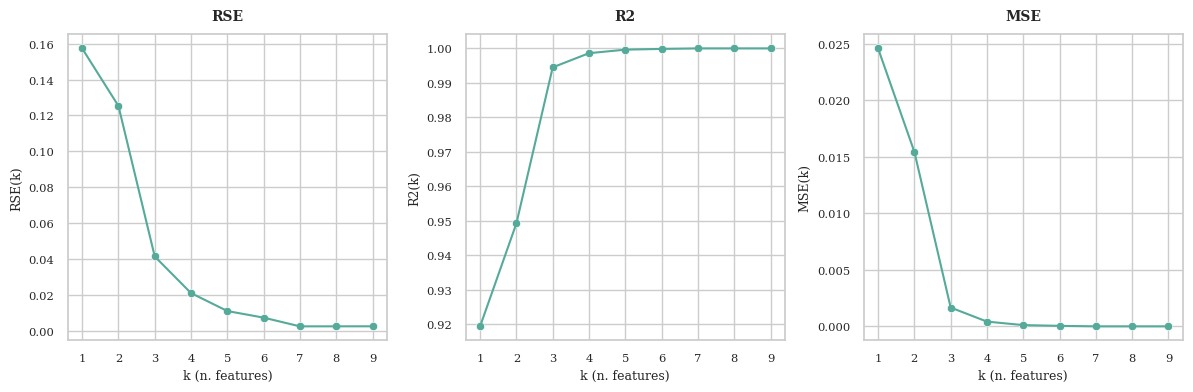

In [67]:
# model
model_name = "(Log) OLS best (forward)"

# criteria and training_method
criteria = "RSE"
training_method = "OLS"

# compute and display the results
list_best_features, list_best_metrics = forward_selection_v2(training_method, X, np.log(y), criteria)
best_features, best_metrics = report_best_parameters(list_best_features, list_best_metrics, criteria, model_name, verbose = True)
plot_metrics(list_best_metrics)

Notice that the selected best model shares the same features as the best linear regression model found before. Hence, in terms of features, transforming the target using the logaritm does not make any change in the result.

Now, in order to compare the accuracy of the best model found here and the one found before, we need to run a $5$-fold cross-validation (with the dataset restricted only to the selected features) making a slight change in the residuals computation, as follows.

We know that a linear relationship between target and predictors is modeled as
$$y = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n + \varepsilon = \hat{y} + \hat{\varepsilon} \, \implies \, \texttt{res} \coloneqq \hat{\varepsilon} = y - \hat{y},$$
while a linear relationship between the logarithm of the target and the predictors is modeled as
$$\log(y) = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n = \widehat{\log(y)} + \hat{\varepsilon} \, \implies \, \texttt{res} \coloneqq \hat{\varepsilon} = \log(y) - \widehat{\log(y)}.$$
Hence, in order to make the residuals of the second model comparable to the residuals of the first model we compute the residuals by estimating $\hat{y}$ with $e^{\widehat{\log(y)}}$, as follows:
$$\texttt{res} = e^{\log(y)} - e^{\widehat{\log(y)}} = y - e^{\widehat{\log(y)}}.$$

In [68]:
# predictors = X[best_features], target = np.log(y)
# (it is necessary to add the intercept in order to apply sm.OLS)
X_best_with_intercept = sm.add_constant(X[best_features])  

# metrics_folds = mean metrics (RSE, R2 and MSE) among the folds
metrics_folds = {
	"RSE": 0,
	"R2": 0,
	"MSE": 0
}

# k-fold
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

# run k-fold cv
for train_idx, validation_idx in kf.split(X_best_with_intercept):
	# split in train and validation
	X_train, X_validation = X_best_with_intercept.iloc[train_idx], X_best_with_intercept.iloc[validation_idx]
	y_log_train, y_log_validation = np.log(y).iloc[train_idx], np.log(y).iloc[validation_idx]

	# fit	
	model = sm.OLS(y_log_train, X_train).fit()

	# predict
	y_log_pred = model.predict(X_validation)

	# compute ad update the regression errors
	y_validation = y[y_log_validation.index]
	RSE, R2, MSE = calculate_metrics(y_validation, np.exp(y_log_pred), len(best_features))
	metrics_folds["RSE"] = metrics_folds["RSE"] + RSE
	metrics_folds["R2"] = metrics_folds["R2"] + R2
	metrics_folds["MSE"] = metrics_folds["MSE"] + MSE

# compute the k-fold metrics
metrics_folds = {key: metrics_folds[key] / number_folds for key in metrics_folds.keys()}

# store cv errors
cv_errors = pd.concat([cv_errors, pd.DataFrame([metrics_folds])])
cv_errors = cv_errors.rename(index = {0: model_name})

display(cv_errors)

,RSE,R2,MSE
OLS best (forward),658.188759,0.998257,413572.984907
Ridge best (alpha = 0.001),658.198925,0.998257,413580.418770
Lasso best (alpha = 0.001),658.189061,0.998257,413573.209576
PCA (k = 9),664.743870,0.998259,412956.193158
PLS (k = 9),664.743870,0.998259,412956.193158
(Log) OLS best (forward),68.736824,0.999981,4578.415573


The above dataframe shows the error metrics of the new model compared to the metrics of the models we considered in **Objective 1**. As we can see, we obtain a considerable reduction both in $\texttt{RSE}$ and $\texttt{MSE}$. Furthermore, the $\texttt{R}^2$ metric improves too. This implies that overall this model is the most accurate so far. Hence, we will consider it too in the solution of **Objective 2**.

### Best (log) linear model analysis

We now fit the model and then check wether the heteroscedasticity problem has been solved. In particular, we plot the training fitted values vs. the training residuals and we perform the *Breush-Pagan Lagrange multiplier test*.

In [69]:
# split in train and test:
# predictors = X[best_features], target = np.log(y)
X_train, X_test, y_log_train, y_log_test = train_test_split(X[best_features], np.log(y), test_size = 0.2, random_state = 2023)

# fit ((log) OLS)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_log_train, X_train_with_intercept).fit()

# predict
y_log_pred = model.predict(X_test_with_intercept)

# model accuracy
RSE, R2, MSE = calculate_metrics(y_log_test, y_log_pred, p = X_train.shape[1])
print(model_name + ", test metrics:\n\t- RSE =", '%.6f' % RSE, "\n\t- R2 =", '%.6f' % R2, "\n\t- MSE =", '%.6f' % MSE)

(Log) OLS best (forward), test metrics:
	- RSE = 0.002549 
	- R2 = 0.999978 
	- MSE = 0.000006


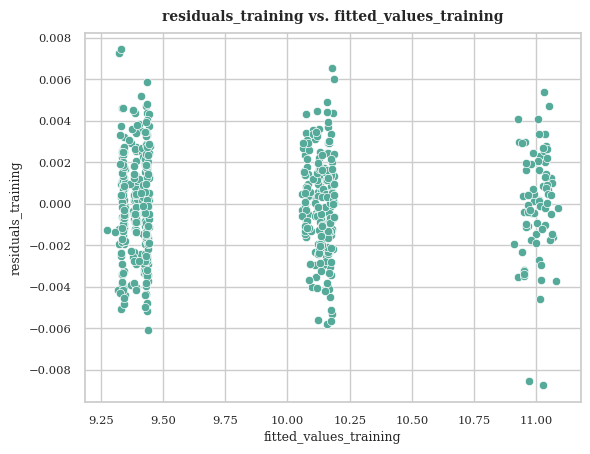

In [70]:
# scatterplot of residuals_training vs. fitted_values_training
residuals_training = model.resid
fig = sns.scatterplot(x = model.predict(X_train_with_intercept), y = residuals_training)
fig.set_title("residuals_training vs. fitted_values_training", weight = "bold", y = 1.01).set_fontsize("10")
fig.set_xlabel("fitted_values_training")
fig.set_ylabel("residuals_training")
plt.show()

In [71]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic =", '%.6f' % lzip(name, test)[0][1], "\n- p-value =", '%.6f' % lzip(name, test)[1][1])

- lagrange multiplier statistic = 5.211360 
- p-value = 0.634187


The above scatterplot shows a nearly constant variance of the residuals: the points in each cloud are approximately uniformely distributed around $0$. This is confirmed by the *Breush-Pagan Lagrange multiplier test*: the *p-value* is higher than $0.05$, hence the null hypothesis ($H_0$) of homoscedasticity is not rejected.

# Objective 2

In this section we explore all the other models we studied throughout the course in order to answer to **Objective 2**. 

From now on we will restrict our dataset to the features obtained by the best linear regression in **Objective 1**. In fact, to be more precise we should perform feature selection for each new method from the `merged_df` dataset. However, we avoid doing this in order not to complicate the report and also because we have already seen that using only these variables results in very high accuracy. <br>
Furthermore, we standardize the dataset since there are methods that could be biased by the difference in magnitude and variance of the predictors. <br>
Last but not least, we decide to use only the $\texttt{MSE}$ metric to assess and compare the models' accuracy, which is always computed via a $5$-fold cross-validation.

In [72]:
# reload the dataset (best_features)
X = merged_df[["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"]]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
y = merged_df["sales_amount"]

display(X_scaled), display(pd.DataFrame(y))

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,-0.618431,0.915552,-0.707107,-0.603023,-0.555788,-0.660396,-0.495555
1,0.517083,-1.092237,1.414214,-0.603023,-0.555788,-0.630949,0.850803
2,0.843765,-1.092237,1.414214,-0.603023,-0.555788,-0.473006,0.010016
3,-0.760729,0.915552,-0.707107,-0.603023,1.799247,-0.415815,-0.951668
4,-0.890714,0.915552,-0.707107,-0.603023,-0.555788,-0.576192,-0.946173
...,...,...,...,...,...,...,...
745,-0.832020,0.915552,-0.707107,-0.603023,-0.555788,-0.443194,-0.363667
746,-0.897586,0.915552,-0.707107,-0.603023,-0.555788,-0.600894,-0.984640
747,0.386238,-1.092237,1.414214,-0.603023,-0.555788,-0.333680,0.823327
748,-0.911615,0.915552,-0.707107,-0.603023,-0.555788,-0.433824,-0.545013


,sales_amount
0,12609.579520
1,26573.814219
2,26124.283769
3,11856.326518
4,12392.551096
...,...
745,12570.549505
746,12375.246473
747,26404.851308
748,12542.256577


(None, None)

Before we start with polynomial regression we initialize the dataframe that will contain the $\texttt{MSE}$ value of each model. We include also the $\texttt{MSE}$ corresponding to the best linear regression found in **Objective 1** and the one corresponding to te best linear model with the logged target.

In [73]:
# change display format of pandas dataframes
pd.set_option('display.float_format', lambda x: '%.6e' % x)

# initialize a dataframe which will contain the test errors obtained with all the models
cv_mse = pd.DataFrame()

## Linear regression and (log) linear regression

In order to obtain comparable $\texttt{MSE}$ values for the models introduced by now we use the standardized dataset and derive again the errors via a $5$-fold cross-validation. 

$\textit{Remark}:$ Actually these two specific cases the standardization of the dataset does not affect the results, but we still decided to recompute the $\texttt{MSE}$ metrics to obtain a more coherent result.

In [74]:
# model
model_name = "Linear regression"

# add constant colums
X_with_intercept = sm.add_constant(X_scaled)  

# mse among the folds
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_with_intercept):
	# split in train and validation
	X_train, X_validation = X_with_intercept.iloc[train_idx], X_with_intercept.iloc[validation_idx]
	y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

	# fit
	model = sm.OLS(y_train, X_train).fit()

	# predict
	y_pred = model.predict(X_validation)

	# compute ad update the MSE
	mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean()

# compute the k-fold MSE
estimated_test_error = mse_folds / number_folds

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

In [75]:
# model
model_name = "(Log) Linear regression"

# add constant colums
X_with_intercept = sm.add_constant(X_scaled)  

# mse among the folds
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_with_intercept):
	# split in train and validation
	X_train, X_validation = X_with_intercept.iloc[train_idx], X_with_intercept.iloc[validation_idx]
	y_log_train, y_log_validation = np.log(y).iloc[train_idx], np.log(y).iloc[validation_idx]

	# fit	
	model = sm.OLS(y_log_train, X_train).fit()

	# predict
	y_log_pred = model.predict(X_validation)

	# compute ad update the MSE
	y_validation = y[y_log_validation.index]
	mse_folds = mse_folds + ((y_validation - np.exp(y_log_pred)) ** 2).mean()

# compute the k-fold MSE
estimated_test_error = mse_folds / number_folds

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03


## Polynomial regressions

We now run polynomial regression from the $2^{\text{nd}}$ to the $4^{\text{th}}$ order.

In [76]:
# polynomial degree d
for d in range(1, 5):
	# model
	model_name = "Poly regression (order = " + str(d) + ")"

	# mse_folds = store MSE among the folds
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		# split in train and validation
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# create polynomials data
		poly = PolynomialFeatures(d)
		X_train_poly = poly.fit_transform(X_train)
		X_validation_poly = poly.fit_transform(X_validation)

		# fit
		model = LinearRegression()
		model.fit(X_train_poly, y_train)

		# predict
		y_pred = model.predict(X_validation_poly)

		# compute ad update the MSE
		mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean()

	# compute the k-fold MSE
	estimated_test_error = mse_folds / number_folds
	
	# store cv errors
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05


It is clear that as the order of the regression increases, there is a significant decrease in performance. This suggests us that the most reasonable model to chose is the quadratic one. <br>
This observation can also be explained on a theoretical level: let us indeed recall that the linear model we studied in **Objective 1** suffers from heteroscedasticity and one of the standard methods to solve this problem is to consider the square root of the target. However, this is entirely equivalent to fitting a model in which the squares of the regressors are considered. Therefore the regression model of order $2$ is better as we are optimising via $\texttt{OLS}$ a non-heteroscedastic model.

## Regression splines

Looking at the plots of the residuals in **Objective 1**, one can detect the presence of three distinct clusters of observations with extremely similar variances. 
This leads us to consider that by fitting a regression splines model, i.e. inserting step functions that divide our dataset into those three clusters, the accuracy of the predictions will increase. <br>
In particular, we use $2$ *knots* to divide our model in $3$ parts:
$$
y = 
\begin{cases} 
	\beta_{0, 1} + \beta_{1, 1} X_1 + \dots + \beta_{n, 1} X_n + \varepsilon_1 & \text{ if } \texttt{is\_mini} = \texttt{True} \\
	\beta_{0, 2} + \beta_{1, 2} X_1 + \dots + \beta_{n, 2} X_n + \varepsilon_2 & \text{ if } \texttt{is\_super} = \texttt{True} \\
	\beta_{0, 3} + \beta_{1, 3} X_1 + \dots + \beta_{n, 3} X_n + \varepsilon_3 & \text{ otherwise }
\end{cases}.
$$
We then decided to extend the reasoning to regressions of higher order than the first to see whether there were improvements given by the increased flexibility of the models within clusters.

$\textit{Remark}:$ It may be interesting to note that in our case we do not have knots with possible continuity/derivability issues as we are exploiting step functions based on categorical variables.

In [77]:
# creation of a list containing the indexes of each market type
mini_index = merged_df[merged_df["is_mini"] == 1].index
super_index = merged_df[merged_df["is_super"] == 1].index
hyper_index = merged_df[(merged_df["is_mini"] == 0) & (merged_df["is_super"] == 0)].index
list_index = [mini_index, super_index, hyper_index]

In [78]:
# polynomial degree d
for d in range(1, 4):
	# model
	if d == 1:
		model_name = "Linear regression splines"
	else:
		model_name = "Poly regression splines (order = " + str(d) + ")"
	
	# mse among the folds
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		# split in train and validation
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# squared residuals among the markets (in the current fold)
		sq_res_markets = pd.DataFrame()
		
		# list_index = [mini_index, super_index, hyper_index] 
		for market_index in list_index:
			# restrict train and validation to the current market
			X_train_market = X_train.loc[X_train.index.intersection(market_index)]
			X_validation_market = X_validation.loc[X_validation.index.intersection(market_index)]
			y_train_market = y_train.loc[y_train.index.intersection(market_index)]
			y_validation_market = y_validation.loc[y_validation.index.intersection(market_index)]

			# create polynomials data
			poly = PolynomialFeatures(d)
			X_train_market_poly = poly.fit_transform(X_train_market)
			X_validation_market_poly = poly.fit_transform(X_validation_market)
			
			# fit
			model = LinearRegression()
			model.fit(X_train_market_poly, y_train_market)
			
			# predict
			y_pred_market = model.predict(X_validation_market_poly)
			
			# update the squared residuals (append the ones corresponding to the current market)
			sq_res_markets = pd.concat([sq_res_markets, (y_validation_market - y_pred_market) ** 2], ignore_index = True)

		# compute ad update the MSE
		mse_folds = mse_folds + sq_res_markets.mean().iloc[0]

	# compute the k-fold MSE
	estimated_test_error = mse_folds / number_folds

	# store cv errors
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04


Our expectations are indeed confirmed. As for the polynomial regression model of order $2$ and the linear regression with the logarithm of the target, the removal of heteroscedasticity allows us to obtain much lower values of $\texttt{MSE}$ (about $2$ orders of magnitude lower) than in the case of linear regression. <br>
By increasing the flexibility of the regression in the intervals, we do not observe any improvement.

## Log linear regression splines

Having noticed that by using both the target logarithm and the step functions we are able to achieve improvements in performance, we wonder what could happen by combining the two techniques, so we try to implement the merged  model.

In [79]:
# model
model_name = "(Log) Linear regression splines"

# mse among the folds
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
	# split in train and validation
	X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
	y_log_train, y_log_validation = np.log(y).iloc[train_idx], np.log(y).iloc[validation_idx]

	# squared residuals among the markets (in the current fold)
	sq_res_markets = pd.DataFrame()
	
	# list_index = [mini_index, super_index, hyper_index] 
	for market_index in list_index:
		# restrict train and validation to the current market
		X_train_market = X_train.loc[X_train.index.intersection(market_index)]
		X_validation_market = X_validation.loc[X_validation.index.intersection(market_index)]
		y_log_train_market = y_log_train.loc[y_log_train.index.intersection(market_index)]
		y_log_validation_market = y_log_validation.loc[y_log_validation.index.intersection(market_index)]
		
		# fit
		model = LinearRegression()
		model.fit(X_train_market, y_log_train_market)

		# predict
		y_log_pred_market = model.predict(X_validation_market)

		# update the squared residuals
		y_validation_market = y[y_log_validation_market.index]
		sq_res_markets = pd.concat([sq_res_markets, (y_validation_market - np.exp(y_log_pred_market)) ** 2], ignore_index = True)

	# compute ad update the MSE
	mse_folds = mse_folds + sq_res_markets.mean().iloc[0]

# compute the k-fold MSE
estimated_test_error = mse_folds / number_folds

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


The result does not suggest an improvement in performance, which indicates that the data within the clusters are probably homoscedastic and therefore do not benefit from the introduction of the logarithm.

## Generalized additive model (GAM)

We proceed with the performance analysis of the *Generalized Additive Models (GAM)* using smoothing splines $(g_i)_{i = 1}^n$ applied to the predictors $(X_i)_{i = 1}^n$ to better exploit the properties of the features. <br>
First, it is necessary to fit, for each predictor, a smoothing spline dependent on a parameter $\lambda$ which controls its smoothness. Then, by setting this parameter, it is possible to proceed in fitting the model.

In [80]:
# best_lmbd_gam = dictionary storing the MSE and lambda value for the best GAM
best_lmbd_gam = {
	"MSE": float("inf"),
	"lmbd": float("inf")
}

# different values of lambda (control smoothness)
for lmbd in [2, 5, 10, 100, 1000]:
	# mse among the folds
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		# split in train and validation
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		s_terms = [s(i, lam = lmbd) for i in range(len(X_train.columns))]
		model = LinearGAM(reduce(lambda x, y: x + y, s_terms))
		model.fit(X_train, y_train)

		# predict
		y_pred = model.predict(X_validation)

		# compute ad update the MSE
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# compute the k-fold MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	# if True we update the best_lmbd_gam dictionary
	if estimated_test_error < best_lmbd_gam["MSE"]:
		best_lmbd_gam["MSE"] = estimated_test_error
		best_lmbd_gam["lmbd"] = lmbd

# model
model_name = "GAM (lambda = " + str(best_lmbd_gam["lmbd"]) + ")"

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": best_lmbd_gam["MSE"]}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


Looking at the value of the automatically selected parameter $\lambda$ we notice that it coincides with the extreme right-hand side of the range in which we were performing the search. This suggests that the *GAM* model emulates an optimisation performed by $\texttt{OLS}$ that can only be reached in the limit of $\lambda \to +\infty$. <br>
We also observe that the $\texttt{MSE}$ associated with this model is quite high, so the estimate is not significantly more accurate than in the case of the linear regression.

We report the plots of the functions $(g_i)_{i = 1}^n$ below, which we therefore expect to be approximately linear maps.

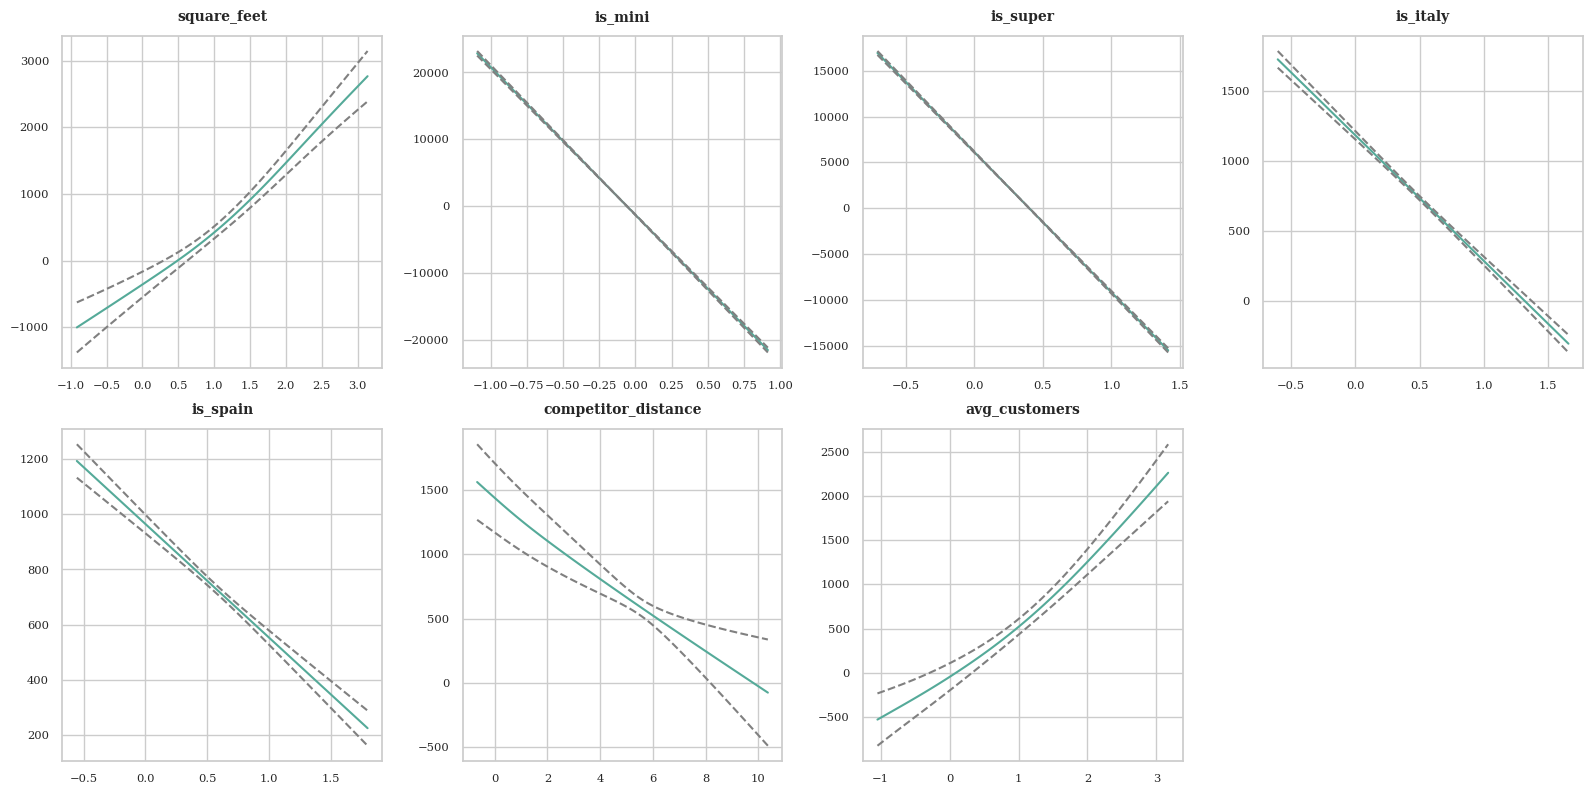

In [81]:
# plot smooth functions used by the GAM model
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))
index = 0
ax = ax.flatten()
for col_name in list(X.columns):
	XX = model.generate_X_grid(term = index)
	sns.lineplot(x = XX[:, index], y = model.partial_dependence(term = index, X = XX), ax = ax[index])
	sns.lineplot(x = XX[:, index], y = model.partial_dependence(term = index, X = XX, width = .95)[1][:, 0], color = "gray", ls = "--", ax = ax[index])
	sns.lineplot(x = XX[:, index], y = model.partial_dependence(term = index, X = XX, width = .95)[1][:, 1], color = "gray", ls = "--", ax = ax[index])
	ax[index].set_title(col_name, weight = "bold", y = 1.02).set_fontsize("10")
	index = index + 1
ax[-1].axis("off")
plt.tight_layout()

$\textit{Remark}:$ The signs of the slopes of the seven lines are consistent with the coefficients found in **Objective 1** via $\texttt{OLS}$.

## Random forests

Let us now analyse the performances of a popular ensemble learning method: the *random forests*. <br>
By exploiting the good properties of decision trees, one could hope to obtain a fairly successful model through this approach. 
The great versatility of the method can be appreciated by looking at the large number of parameters that can be set. We tried to train the model with many different parameters and attempted to obtain the most accurate result possible.

$\textit{Remark}:$ We note that setting `n_estimators` $= 1$ yields a single decision tree, and setting `max_features` $= \texttt{None}$ instead makes it possible to replicate the so-called *bagged trees* model.

In [82]:
# best_params = dictionary storing the MSE and the best parameters for the random forests model
best_params = {
	"MSE": float("inf"),
	"params": [-1, -1, None] # = [n_estimators, min_samples_split, max_features]
}

# different parameters tested
list_parameters = [
	[1, 2, "sqrt"], [1, 5, "sqrt"], [1, 10, "sqrt"], 			# single tree
	[1, 2, None], [1, 5, None], [1, 10, None],					# single tree, all features
	[100, 2, "sqrt"], [100, 5, "sqrt"], [100, 10, "sqrt"],		# 100 trees
	[1000, 2, "sqrt"], [1000, 5, "sqrt"], [1000, 10, "sqrt"],	# 1000 trees 
	[1000, 2, None], [1000, 5, None], [1000, 10, None]]			# 1000 trees, all features (= bagged trees)

print("n. parameters tested, (n. trees, min. samples split, n. features):")
counter = 0

for params in list_parameters:
	# print state
	counter = counter + 1
	print("\t- " + (str(counter) if counter > 9 else "0" + str(counter)) + "/" + str(len(list_parameters)) + \
		", (" + str(params[0]) + ", " + str(params[1]) + ", " + \
		(str(X_scaled.shape[1]) if params[2] == None else "sqrt(" + str(X_scaled.shape[1]) + ")") + ")")

	# mse among the folds
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		# split
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		model = RandomForestRegressor(n_estimators = params[0], min_samples_split = params[1], max_features = params[2], random_state = 2023)
		model.fit(X_train, y_train)

		# predict
		y_pred = model.predict(X_validation)

		#  compute ad update the MSE
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# compute the k-fold MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	# if True we update the best_params dictionary
	if estimated_test_error < best_params["MSE"]:
		best_params["MSE"] = estimated_test_error
		best_params["params"] = params

# model
best_params["params"][2] = str(X_scaled.shape[1]) if best_params["params"][2] == None else "sqrt(" + str(X_scaled.shape[1]) + ")"
model_name = "Random forests (" + str(best_params["params"][0]) + " trees, " + str(best_params["params"][1]) + \
	" samples split, " + str(best_params["params"][2]) + " features)"

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": best_params["MSE"]}])], ignore_index = True)

display(cv_mse)

n. parameters tested, (n. trees, min. samples split, n. features):
	- 01/15, (1, 2, sqrt(7))
	- 02/15, (1, 5, sqrt(7))
	- 03/15, (1, 10, sqrt(7))
	- 04/15, (1, 2, 7)
	- 05/15, (1, 5, 7)
	- 06/15, (1, 10, 7)
	- 07/15, (100, 2, sqrt(7))
	- 08/15, (100, 5, sqrt(7))
	- 09/15, (100, 10, sqrt(7))
	- 10/15, (1000, 2, sqrt(7))
	- 11/15, (1000, 5, sqrt(7))
	- 12/15, (1000, 10, sqrt(7))
	- 13/15, (1000, 2, 7)
	- 14/15, (1000, 5, 7)
	- 15/15, (1000, 10, 7)


,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


The best combination of parameters results in selecting $1000$ trees, set the `min_sample_split` number to $2$ (the minimum number of samples required to split an internal node) and exploit all $7$ available features (i.e. we are in the case of *bagged trees*). <br>
However, even the best set of parameters does not allow us to achieve the precision found by regressions in the cases where heteroscedasticity is removed.

## Gradient boosting

Let us move on by considering a boosting method in the context of regression, namely *gradient boosting*. <br>
This method is based on learning, step by step, the residuals generated at the previous step. It necessitates the choice of a *learning rate* in order to be exploited to its full potential.

In [83]:
# best_lr = dictionary storing the MSE and learning rat for the best gradient boosting model
best_lr = {
	"MSE": float("inf"),
	"lr": float("inf")
}

# different values of lr
for lr in [0.001, 0.01, 0.1, 0.5]:
	# mse among the folds
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		# split in train and validation
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		model = GradientBoostingRegressor(n_estimators = 1000, max_leaf_nodes = 32, learning_rate = lr, random_state = 2023)
		model.fit(X_train, y_train)

		# predict
		y_pred = model.predict(X_validation)

		# compute ad update the MSE
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# compute the k-fold MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	# if True we update the best_lr dictionary
	if estimated_test_error < best_lr["MSE"]:
		best_lr["MSE"] = estimated_test_error
		best_lr["lr"] = lr

# model
model_name = "Gradient boosting (learning rate = " + str(best_lr["lr"]) + ")"

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": best_lr["MSE"]}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


The accuracy of the method, measured by means of the $\texttt{MSE}$ value, is comparable to the one of the *random forests*, unfortunately an order of magnitude worse than the best models found so far.

## Support vector machine (SVM)

We proceed by studying the performance of *support vector machines (SVM)*, a very popular method in the context of classification, but which also has applications in regression problems.

In [84]:
# set the parameters (we setted a polynomial kernel)
parameters = {
	"C": np.linspace(1, 100, 10).tolist(), 
	"kernel": ["poly"],
	"gamma": ["scale", "auto"] + np.linspace(0.01, 1, 10).tolist()
}
svm = SVR()
grid_search = GridSearchCV(svm, parameters, cv = 5)
grid_search.fit(X_scaled, y)
best_params = grid_search.best_params_

# model
model_name = "SVM (C = " + str(list(best_params.values())[0]) + ", gamma = " + str(list(best_params.values())[1]) + \
	", ker = " + str(list(best_params.values())[2]) + ")"

# mse among the folds
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
	# split in train and validation
	X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
	y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit 
	model = SVR(C = best_params["C"], kernel = best_params["kernel"], gamma = best_params["gamma"])
	model.fit(X_train, y_train)

	# predict
	y_pred = model.predict(X_validation)

	# compute ad update the MSE
	mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean()

# compute the k-fold MSE
estimated_test_error = mse_folds / number_folds

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


Surprisingly, even when trying to exploit polynomial kernels (which produce a more accurate result than their linear counterparts and radial basis functions), the accuracy of *SVMs* is the worst compared to all models tested so far.

## Neural Network (NN)

We conclude by analyzing one of the most popular models in recent years, the *neural networks (NNs)*.
In contrast to what has been done so far, in order to exploit the potential of this model, it is necessary to exploit $\texttt{PyTorch}$ one of the main libraries dedicated to them. <br>
We therefore begin by setting the library parameters to allow the selection of the device on which the operations will be performed.

In [85]:
# set device (gpu or cpu)
gpu_flag = False
if gpu_flag:
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print("using device " + str(device) + ": ", end = "")
	if device.type == "cuda":
		print(torch.cuda.get_device_name(0), end = "")
		print(" (cuda version " + torch.version.cuda + ")")
else:
	device = torch.device("cpu")
	print("using device " + str(device))

using device cpu


This class of machine learning tools is, of all those seen, the broadest and most versatile. To initialise and fit a *neural network* it is necessary to choose an *architecture* and adjust various *learning* parameters. Below are reported the parameters we have chosen to use in implementing our network:
- *architecture*:
    - `input_size` $=$ `X.shape[1]`;
    - `hidden_sizes` $= [50, 50]$ (each hidden layer have $50$ neurons); 
    - `output_size` $= 1$;
	- `activation` $=$ `nn.ReLU`.
- *learning* parameters:
	- `learning_rate` $= 7 \cdot 10^{-8}$;
	- `num_epochs` $= 200$;
	- `batch_size` $= 5$;
	- `criterion` = `nn.MSELoss`.

$\textit{Remark}:$ In order to select the parameters for our *NN* we proceeded by trial and error, by orienting ourselves with the plots of the logarithms of the *loss functions* obtained during the training phase of each of the $5$ folds.

fold 1:
	epoch 20/200	| (training) loss: 6514.0810546875
	epoch 40/200	| (training) loss: 304.0568847656
	epoch 60/200	| (training) loss: 929.7327880859
	epoch 80/200	| (training) loss: 1105.9274902344
	epoch 100/200	| (training) loss: 1087.8760986328
	epoch 120/200	| (training) loss: 1178.2353515625
	epoch 140/200	| (training) loss: 1303.4272460938
	epoch 160/200	| (training) loss: 1378.8815917969
	epoch 180/200	| (training) loss: 1446.6535644531
	epoch 200/200	| (training) loss: 1527.2637939453
fold 2:
	epoch 20/200	| (training) loss: 5957.0117187500
	epoch 40/200	| (training) loss: 1077.1534423828
	epoch 60/200	| (training) loss: 911.0828857422
	epoch 80/200	| (training) loss: 1006.5900268555
	epoch 100/200	| (training) loss: 1071.4594726562
	epoch 120/200	| (training) loss: 1084.1562500000
	epoch 140/200	| (training) loss: 1127.7136230469
	epoch 160/200	| (training) loss: 1155.2145996094
	epoch 180/200	| (training) loss: 1189.0895996094
	epoch 200/200	| (training) loss: 1200.287475

,model,MSE
0,Linear regression,4.135730e+05
1,(Log) Linear regression,4.578416e+03
2,Poly regression (order = 1),4.135730e+05
3,Poly regression (order = 2),4.926164e+03
4,Poly regression (order = 3),7.618251e+03
5,Poly regression (order = 4),5.157096e+05
6,Linear regression splines,4.809525e+03
7,Poly regression splines (order = 2),6.244661e+03
8,Poly regression splines (order = 3),6.692353e+04
9,(Log) Linear regression splines,4.605329e+03


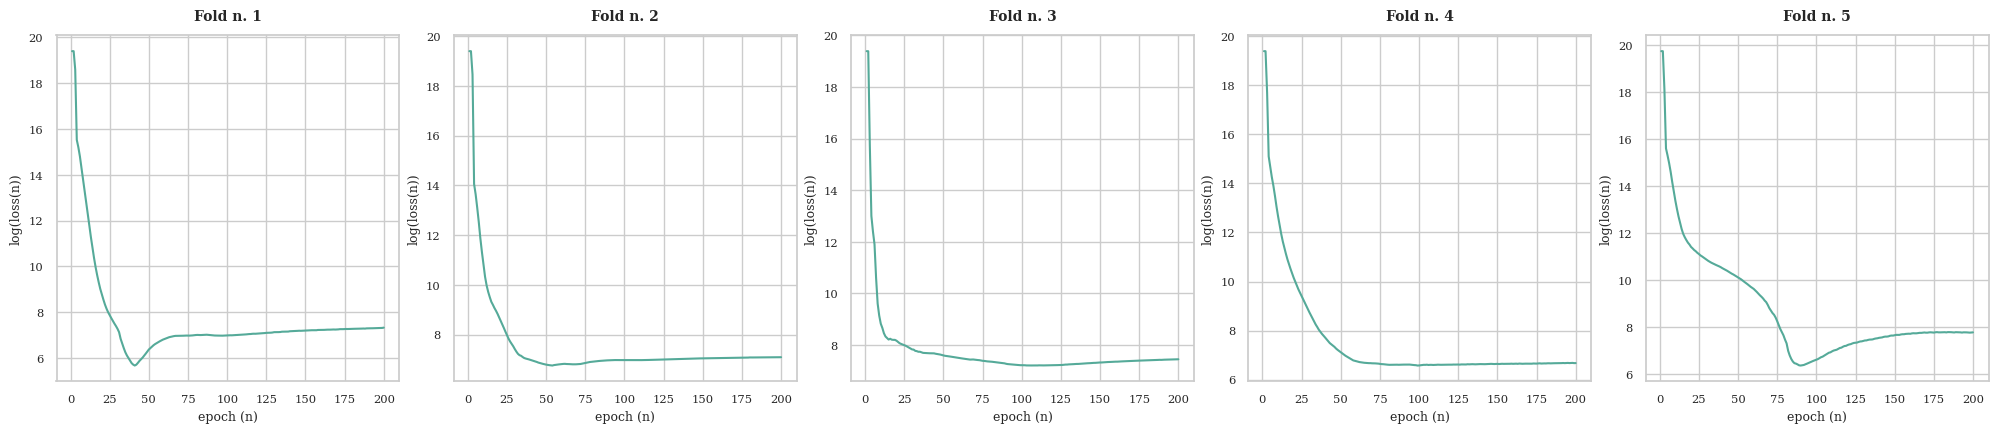

In [86]:
torch.manual_seed(2023)

# predictors = X_scaled_nn, target = y_nn
X_scaled_nn = scaler.fit_transform(X)
y_nn = y.to_numpy().reshape(-1, 1)

# nn_model initialization
input_size = X_scaled_nn.shape[1]
hidden_sizes = [50, 50]
output_size = 1
activation = nn.ReLU()
def nn_model(input_size, hidden_sizes, output_size):
	layers = []
	for i in range(len(hidden_sizes)):
		if i == 0:
			layers.append(nn.Linear(input_size, hidden_sizes[i]))
		else:
			layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
		layers.append(activation)
	layers.append(nn.Linear(hidden_sizes[-1], output_size))
	return nn.Sequential(*layers)

# learning parameters
learning_rate = 7e-8
num_epochs = 200
batch_size = 5
criterion = nn.MSELoss()

# model
model_name = "NN (" + str(len(hidden_sizes)) + " hidden layers, ReLU act.)"

# mse among the folds
mse_folds = 0

# creation of plot environment for the loss functions
_, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 4))
ax = ax.flatten()
plt.tight_layout()

# run k-fold cv
fold_counter = 0
for train_idx, validation_idx in kf.split(X_scaled_nn):
	fold_counter = fold_counter + 1
	print("fold " + str(fold_counter) + ":")

	# split in train and validation (also cast them in tensors)
	X_train, X_validation = X_scaled_nn[train_idx, :], X_scaled_nn[validation_idx, :]
	y_train, y_validation = y_nn[train_idx], y_nn[validation_idx]
	X_train_tensor, X_val_tensor = torch.FloatTensor(X_train).to(device), torch.FloatTensor(X_validation).to(device)
	y_train_tensor, y_val_tensor = torch.FloatTensor(y_train).to(device), torch.FloatTensor(y_validation).to(device)
	
	# model init
	model = nn_model(input_size, hidden_sizes, output_size)
	model = model.to(device)
	# optimizer init
	optimizer = optim.SGD(model.parameters(), lr = learning_rate)

	# cv_losses = list of the losses during the epochs
	cv_losses = []

	# fit (epochs)
	for epoch in range(num_epochs):
		for batch_start in range(0, X_train_tensor.size(0), batch_size):
			# restict to batch
			X_batch = X_train_tensor[batch_start:(batch_start + batch_size)]
			y_batch = y_train_tensor[batch_start:(batch_start + batch_size)]
			
			# forward pass
			outputs = model.forward(X_batch)
			loss = criterion(outputs, y_batch)

			# backward pass and optimization
			optimizer.zero_grad() 
			loss.backward()
			optimizer.step()

		# loading (printed every 20 epochs)
		if (epoch + 1) % 20 == 0:
			print("\tepoch " + str(epoch + 1) + "/" + str(num_epochs) + "\t| (training) loss:", "{:.10f}".format(loss.item()))
		cv_losses.append(loss.item())

	# plot log of cv_losses
	sns.lineplot(x = range(1, num_epochs + 1), y = np.log(cv_losses), ax = ax[fold_counter - 1])
	ax[fold_counter - 1].set_title("Fold n. " + str(fold_counter), weight = "bold", y = 1.02).set_fontsize("10")
	ax[fold_counter - 1].set_xlabel("epoch (n)")
	ax[fold_counter - 1].set_ylabel("log(loss(n))")

	# predict
	with torch.no_grad():
		model.eval()
		y_pred = model.forward(X_val_tensor)
		valid_loss = criterion(y_pred, y_val_tensor)
		mse_folds = mse_folds + valid_loss.item()

# compute the k-fold MSE
estimated_test_error = mse_folds / number_folds

# store cv errors
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"model": model_name, "MSE": estimated_test_error}])], ignore_index = True)

display(cv_mse)

Thanks to the great elasticity of the model, we are able to obtain a fairly low $\texttt{MSE}$, comparable in magnitude to our best results.

## Solution

Now we select, among the models we explored above, the best ones in terms of $\texttt{MSE}$. We fit the chosen models on all the available observations and then we apply them to the given options in order to select the most profitable market per each type.

We load below the $3$ lists of options (divided in distinct dataframes by `market_type`).

In [87]:
options_mini = pd.DataFrame(
	np.array([
		[1850, 1, 0, 0, 1, 4500, 190], 
		[2100, 1, 0, 0, 0, 12850, 215], 
		[1920, 1, 0, 1, 0, 1450, 220]]), 
	columns = ["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"])
options_mini.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)

options_super = pd.DataFrame(
	np.array([
		[5580, 0, 1, 0, 1, 580, 420], 
		[5120, 0, 1, 0, 0, 2560, 390], 
		[4970, 0, 1, 1, 0, 3520, 410]]), 
	columns = ["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"])
options_super.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)

options_hyper = pd.DataFrame(
	np.array([
		[10560, 0, 0, 0, 1, 8940, 860], 
		[12570, 0, 0, 0, 0, 7580, 880], 
		[11980, 0, 0, 1, 0, 11560, 790]]), 
	columns = ["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"])
options_hyper.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)

display(options_mini, options_super, options_hyper)

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
SPAIN,1850,1,0,0,1,4500,190
FRANCE,2100,1,0,0,0,12850,215
ITALY,1920,1,0,1,0,1450,220


,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
SPAIN,5580,0,1,0,1,580,420
FRANCE,5120,0,1,0,0,2560,390
ITALY,4970,0,1,1,0,3520,410


,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
SPAIN,10560,0,0,0,1,8940,860
FRANCE,12570,0,0,0,0,7580,880
ITALY,11980,0,0,1,0,11560,790


Let us display the sorted dataframe with all the $\texttt{MSE}$ values.

In [88]:
display(cv_mse.sort_values(by = ["MSE"]))

,model,MSE
1,(Log) Linear regression,4.578416e+03
9,(Log) Linear regression splines,4.605329e+03
6,Linear regression splines,4.809525e+03
3,Poly regression (order = 2),4.926164e+03
7,Poly regression splines (order = 2),6.244661e+03
4,Poly regression (order = 3),7.618251e+03
14,"NN (2 hidden layers, ReLU act.)",8.021353e+03
12,Gradient boosting (learning rate = 0.1),2.686622e+04
11,"Random forests (1000 trees, 2 samples split, 7...",4.801635e+04
8,Poly regression splines (order = 3),6.692353e+04


We select some of the best models, according to the $\texttt{MSE}$ metric. We report them in order:
1. *(Log) Linear regression*;
2. *Linear regression splines*;
3. *Poly regression (order = 2)*;
4. *NN (2 hidden layers, ReLU act.)*.

$\textit{Remark}:$ We choose not to apply *(Log) Linear regression splines*, *Poly regression splines (order = 2)* and *Poly regression (order = 3)* because they are just small modifications of other selected models which are better in terms of $\texttt{MSE}$ metric.

We first reload $X$ and $y$, we then proceed by fitting the $4$ models of interest and printing the results of the predictions on the $3$ small datasets.

In [89]:
# change display format of pandas dataframes
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# reload the dataset (best_features)
X = merged_df[["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"]]
y = merged_df["sales_amount"]

### (Log) Linear regression

Let us start with the most accurate model, namely the linear regression model that considers the logarithm of `sales_amounts` as target in order to reduce the heteroscedasticity.

In [90]:
# add constant columns (required by sm.OLS)
X_with_intercept = sm.add_constant(X)
options_mini_with_intercept = sm.add_constant(options_mini, has_constant = "add")
options_super_with_intercept = sm.add_constant(options_super, has_constant = "add")
options_hyper_with_intercept = sm.add_constant(options_hyper, has_constant = "add")

# fit
model = sm.OLS(np.log(y), X_with_intercept).fit()

# predict
# - mini
y_pred_mini = np.exp(model.predict(options_mini_with_intercept))
y_pred_mini = pd.DataFrame(y_pred_mini.rename("MINI", inplace = True))
# - super
y_pred_super = np.exp(model.predict(options_super_with_intercept))
y_pred_super = pd.DataFrame(y_pred_super.rename("SUPER", inplace = True))
# - hyper
y_pred_hyper = np.exp(model.predict(options_hyper_with_intercept))
y_pred_hyper = pd.DataFrame(y_pred_hyper.rename("HYPER", inplace = True))

log_linear_predictions = pd.concat([y_pred_mini, y_pred_super, y_pred_hyper], axis = 1)
display(log_linear_predictions)

,MINI,SUPER,HYPER
SPAIN,11878.78,25023.86,60188.39
FRANCE,12386.90,26008.18,64015.10
ITALY,11387.15,23649.00,57227.28


### Linear regression splines

We then proceed with regression splines, which exploit the division of the data in clusters to build a more accurate model.

In [91]:
# squared residuals among the markets
sq_res_markets = pd.DataFrame()

# list_index = [mini_index, super_index, hyper_index] 
market_types = ["MINI", "SUPER", "HYPER"]

counter = -1
for market_index in list_index:
	counter = counter + 1

	# restrict data to the current market
	X_market = X.loc[X.index.intersection(market_index)]
	y_market = y.loc[y.index.intersection(market_index)]

	# fit
	model = LinearRegression()
	model.fit(X_market, y_market)
	
	# predict
	if market_types[counter] == "MINI":
		# - mini
		y_pred_mini = model.predict(options_mini)
		y_pred_mini = pd.DataFrame(y_pred_mini)
		y_pred_mini.rename(columns = {0: "MINI"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
	elif market_types[counter] == "SUPER":
		# - super
		y_pred_super = model.predict(options_super)
		y_pred_super = pd.DataFrame(y_pred_super)
		y_pred_super.rename(columns = {0: "SUPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
	elif market_types[counter] == "HYPER":
		# - hyper
		y_pred_hyper = model.predict(options_hyper)
		y_pred_hyper = pd.DataFrame(y_pred_hyper)
		y_pred_hyper.rename(columns = {0: "HYPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)		

linear_splines_predictions = pd.concat([y_pred_mini, y_pred_super, y_pred_hyper], axis = 1)
display(linear_splines_predictions)

,MINI,SUPER,HYPER
SPAIN,11876.42,25026.14,60206.68
FRANCE,12391.97,26015.10,63948.75
ITALY,11389.88,23651.59,57172.84


### Poly regression (order = 2)

Next, we move to the polynomial regression of order $2$, which in its own way again reduces the heteroskedasticity that affects the performance of the optimisation via $\texttt{OLS}$ of the linear regression .

In [92]:
# create polynomials data
d = 2
poly = PolynomialFeatures(d)
X_poly = poly.fit_transform(X)
options_mini_poly = poly.fit_transform(options_mini)
options_super_poly = poly.fit_transform(options_super)
options_hyper_poly = poly.fit_transform(options_hyper)

# fit
model = LinearRegression()
model.fit(X_poly, y)

# predict
# - mini
y_pred_mini = model.predict(options_mini_poly)
y_pred_mini = pd.DataFrame(y_pred_mini)
y_pred_mini.rename(columns = {0: "MINI"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
# - super
y_pred_super = model.predict(options_super_poly)
y_pred_super = pd.DataFrame(y_pred_super)
y_pred_super.rename(columns = {0: "SUPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
# - hyper
y_pred_hyper = model.predict(options_hyper_poly)
y_pred_hyper = pd.DataFrame(y_pred_hyper)
y_pred_hyper.rename(columns = {0: "HYPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)

poly_2_predictions = pd.concat([y_pred_mini, y_pred_super, y_pred_hyper], axis = 1)
display(poly_2_predictions)

,MINI,SUPER,HYPER
SPAIN,11874.73,25023.12,60236.09
FRANCE,12389.01,26001.36,64014.60
ITALY,11384.97,23655.43,57180.77


### NN (2 hidden layers, ReLU)

Finally, we proceed with training and prediction using a *neural network*. We report, as we did during the cross-validation procedure, the plot of the logarithm of the training loss. <br>

$\textit{Remark}:$ In order to use the NN with the previously set parameters, it is necessary to have standardized inputs. We therefore proceed by standardizing the new $9$ observations together with the $750$ observations already present.

epoch 20/200	| (training) loss: 10454.2851562500
epoch 40/200	| (training) loss: 1769.5302734375
epoch 60/200	| (training) loss: 741.5400390625
epoch 80/200	| (training) loss: 641.2630004883
epoch 100/200	| (training) loss: 607.8076171875
epoch 120/200	| (training) loss: 613.4608154297
epoch 140/200	| (training) loss: 657.9238281250
epoch 160/200	| (training) loss: 731.3497314453
epoch 180/200	| (training) loss: 767.8889770508
epoch 200/200	| (training) loss: 793.8192138672


,MINI,SUPER,HYPER
SPAIN,11795.60,24869.15,60007.79
FRANCE,12306.14,25871.30,63871.57
ITALY,11367.41,23475.89,57040.19


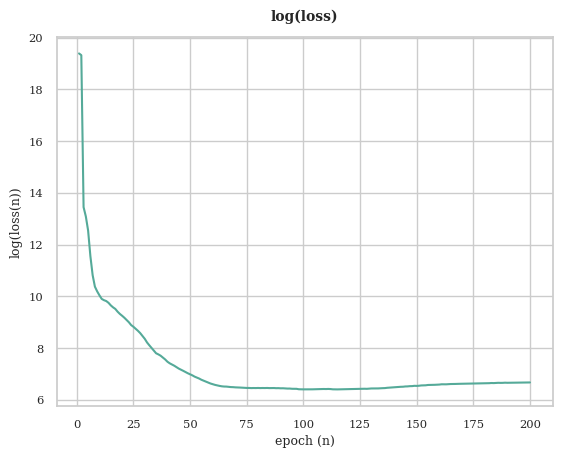

In [93]:
# options_mini/super/hyper_scaled = options_mini/super/hyper rescaled
X_with_new_obs = pd.concat([X, options_mini, options_super, options_hyper], axis = 0)
X_with_new_obs = pd.DataFrame(scaler.fit_transform(X_with_new_obs))
X_with_new_obs = X_with_new_obs.rename(columns = \
	{0: "square_feet", 1: "is_mini", 2: "is_super", 3: "is_italy", 4: "is_spain", 5: "competitor_distance", 6: "avg_customers"})
options_mini_scaled = X_with_new_obs.iloc[-9:-6].reset_index(drop = True)
options_mini_scaled.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
options_super_scaled = X_with_new_obs.iloc[-6:-3].reset_index(drop = True)
options_super_scaled.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)
options_hyper_scaled = X_with_new_obs.iloc[-3:].reset_index(drop = True)
options_hyper_scaled.rename(index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"}, inplace = True)

# X_nn, y_nn = X, y reshaped with numpy
# options_mini/super/hyper_nn = options_mini/super/hyper reshaped with numpy
X_scaled_nn = scaler.fit_transform(X)
y_nn = y.to_numpy().reshape(-1, 1)
options_mini_scaled_nn = options_mini_scaled.to_numpy()
options_super_scaled_nn = options_super_scaled.to_numpy()
options_hyper_scaled_nn = options_hyper_scaled.to_numpy()
# X_tensor = casted X_nn, y_tensor = casted y_nn
X_tensor = torch.FloatTensor(X_scaled_nn).to(device)
y_tensor = torch.FloatTensor(y_nn).to(device)
options_mini_tensor = torch.FloatTensor(options_mini_scaled_nn).to(device)
options_super_tensor = torch.FloatTensor(options_super_scaled_nn).to(device)
options_hyper_tensor = torch.FloatTensor(options_hyper_scaled_nn).to(device)

# model init
model = nn_model(input_size, hidden_sizes, output_size)
model = model.to(device)
# optimizer init
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# list of the losses (during the epochs)
cv_losses = []

# fit (epochs)
for epoch in range(num_epochs):
	for batch_start in range(0, X_tensor.size(0), batch_size):
		# restict to batch
		X_batch = X_tensor[batch_start:(batch_start + batch_size)]
		y_batch = y_tensor[batch_start:(batch_start + batch_size)]
		
		# forward pass
		outputs = model.forward(X_batch)
		loss = criterion(outputs, y_batch)

		# backward pass and optimization
		optimizer.zero_grad() 
		loss.backward()
		optimizer.step()

	# loading (printed every 20 epochs)
	if (epoch + 1) % 20 == 0:
		print("epoch " + str(epoch + 1) + "/" + str(num_epochs) + "\t| (training) loss:", "{:.10f}".format(loss.item()))
	cv_losses.append(loss.item())

# plot log of cv_losses
fig = sns.lineplot(x = range(1, num_epochs + 1), y = np.log(cv_losses))
fig.set_title("log(loss)", weight = "bold", y = 1.02).set_fontsize("10")
fig.set_xlabel("epoch (n)")
fig.set_ylabel("log(loss(n))")

# predict
with torch.no_grad():
	model.eval()
	# - mini
	y_pred_mini = model.forward(options_mini_tensor)
	y_pred_mini = pd.DataFrame(y_pred_mini).rename(columns = {0: "MINI"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"})
	# - super
	y_pred_super = model.forward(options_super_tensor)
	y_pred_super = pd.DataFrame(y_pred_super).rename(columns = {0: "SUPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"})
	# - hyper
	y_pred_hyper = model.forward(options_hyper_tensor)
	y_pred_hyper = pd.DataFrame(y_pred_hyper).rename(columns = {0: "HYPER"}, index = {0: "SPAIN", 1: "FRANCE", 2: "ITALY"})

nn_predictions = pd.concat([y_pred_mini, y_pred_super, y_pred_hyper], axis = 1)
display(nn_predictions)

### Conclusions

We report below, in a compact form, all the results obtained by applying the learning methods just mentioned.

In [94]:
print("(Log) Linear regression")
display(log_linear_predictions)
print("Linear regression splines")
display(linear_splines_predictions)
print("Poly regression (order = 2)")
display(poly_2_predictions)
print("NN (2 hidden layers, ReLU act.)")
display(nn_predictions)

(Log) Linear regression


,MINI,SUPER,HYPER
SPAIN,11878.78,25023.86,60188.39
FRANCE,12386.90,26008.18,64015.10
ITALY,11387.15,23649.00,57227.28


Linear regression splines


,MINI,SUPER,HYPER
SPAIN,11876.42,25026.14,60206.68
FRANCE,12391.97,26015.10,63948.75
ITALY,11389.88,23651.59,57172.84


Poly regression (order = 2)


,MINI,SUPER,HYPER
SPAIN,11874.73,25023.12,60236.09
FRANCE,12389.01,26001.36,64014.60
ITALY,11384.97,23655.43,57180.77


NN (2 hidden layers, ReLU act.)


,MINI,SUPER,HYPER
SPAIN,11795.60,24869.15,60007.79
FRANCE,12306.14,25871.30,63871.57
ITALY,11367.41,23475.89,57040.19


We can observe that, regardless of the market type (`market_type`), all of the $4$ best models we have trained agree that the best country in which to open a market is $\texttt{FRANCE}$. <br>
This result is consistent with what we expected, as we had already noticed from the analysis of the coefficients of the regression optimised by $\texttt{OLS}$ in **Objective 1** that a *punishment* was assigned to the markets located in $\texttt{ITALY}$ and in $\texttt{SPAIN}$.